In [97]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 50)

import datetime
from collections import defaultdict

In [4]:
# Importing San Fransisco EMS Data
# df = pd.read_csv('/Users/tcbon/Downloads/Fire_Department_Calls_for_Service.csv')

In [7]:
# Initial Pickle after Import
redo_pickle = False

if redo_pickle == True:
    with open('sf_ems_raw.pickle','wb') as f:
        pickle.dump(df,f)
        
if redo_pickle == False:
    with open('sf_ems_raw.pickle','rb') as f:
        df = pickle.load(f)

### Data Questions:
- Which stations have the fastest/slowest response times?
- What areas in the city have the most/least medical calls?
- what areas in the city have the most/least code 3 transports?
- Which stations have the fastest/slowest on scene time for code 3 transports?
- Which stations have the most/least code 2 transports? 
- Which stations have the highest amount of nonurgent calls, not requiring ems?
- 
- do linear regression to predict how long it will take to respond
- predict 

- build on online app which ranks the best and worst ems stations that day/week/month
    - you can pick which areas in sf you live in and see how it compares to other places
    
- draw your own fire district or create interactive heatmap that changes based on the type of call and weather, seasonality

- time series on predicting what calls will happen where
- aws, sql, pyspark

### Data Preprocessing

In [41]:
# Selecting all columns to be changed to datetime format
datetime_col_names = ['Call Date','Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
                      'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm', 'Available DtTm']

In [42]:
# Changing selected files to datetime format
for name in datetime_col_names:
    df[name] = pd.to_datetime(df[name]) 

In [3]:
# Pickle after datetime update
redo_pickle = False

if redo_pickle == True:
    with open('sf_ems_dt.pickle','wb') as f:
        pickle.dump(df,f)
        
if redo_pickle == False:
    with open('sf_ems_dt.pickle','rb') as f:
        df = pickle.load(f)

### Feature Engineering - Time Intervals

In [4]:
### Adding Time Columns
df['Fire_Response_Time'] = (df['On Scene DtTm'] - df['Dispatch DtTm']).dt.total_seconds()
df['On_Scene_Time'] = (df['Transport DtTm'] - df['On Scene DtTm']).dt.total_seconds()
df['Transport_Time'] = (df['Hospital DtTm'] - df['Transport DtTm']).dt.total_seconds()
df['Hospital_to_Avail_Time'] = (df['Available DtTm'] - df['Hospital DtTm']).dt.total_seconds()
df['Unavailable_Time'] = (df['Available DtTm'] - df['Dispatch DtTm']).dt.total_seconds()

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


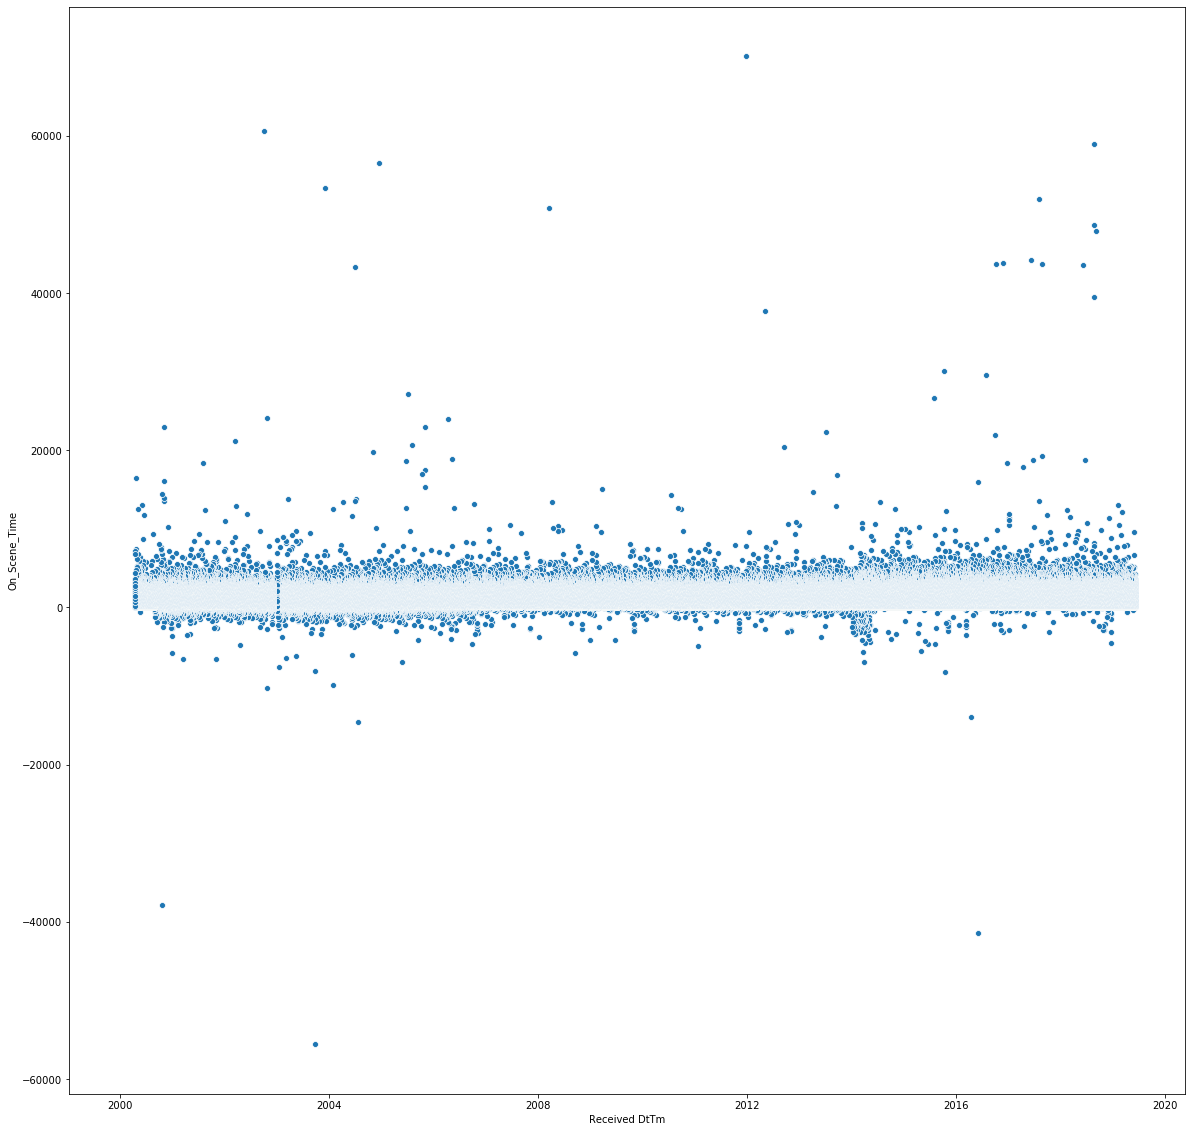

In [5]:
# Plotting on scene time over 20 years -> Found negative times(indicates errors in data)
plt.figure(figsize=(20,20))
sns.scatterplot(df['Received DtTm'],df['On_Scene_Time']);

### Cleaning Time Entry Mistakes 

In [6]:
# Finding number of time mistakes
print('Fire_Response_Time:',len(df[df['Fire_Response_Time'] < 0]))
print('On_Scene_Time:',len(df[df['On_Scene_Time'] < 0]))
print('Transport_Time:',len(df[df['Transport_Time'] < 0]))
print('Hospital_to_Avail_Time:',len(df[df['Hospital_to_Avail_Time'] < 0]))
print('Unavailable_Time:',len(df[df['Unavailable_Time'] < 0]))

Fire_Response_Time: 427
On_Scene_Time: 6114
Transport_Time: 3478
Hospital_to_Avail_Time: 8314
Unavailable_Time: 293


In [7]:
# Finding percentage of negative times
(len(df[df['Fire_Response_Time'] < 0])\
 + len(df[df['On_Scene_Time'] < 0])\
 + len(df[df['Transport_Time'] < 0])\
 + len(df[df['Hospital_to_Avail_Time'] < 0])\
 + len(df[df['Unavailable_Time'] < 0])) /len(df)

0.0037456550220755546

In [8]:
# Checking for even distribution of mistakes across SF neighborhoods
time_list = ['Fire_Response_Time','On_Scene_Time','Transport_Time','Hospital_to_Avail_Time','Unavailable_Time']
neighborhood_list = df['Neighborhooods - Analysis Boundaries'].value_counts().index
mistake_df = pd.DataFrame(index=neighborhood_list)
# Adding columns for percentage of errors for each neighborhood 
for column in time_list:
    mistake_df = mistake_df.merge(pd.DataFrame((df[(df[column] < 0)]['Neighborhooods - Analysis Boundaries'].value_counts()/
     df['Neighborhooods - Analysis Boundaries'].value_counts())),
                                  left_index=True,right_index=True)
# renaming columns
mistake_df.columns = time_list\

# Adding up all mistakes
mistake_df['Total'] = mistake_df.sum(axis=1)

In [9]:
# Ratio of all time entry mistakes per neighborhood call volume:
# There are no neighborhoods that will be grossly affected by this deletion in comparison to others
# so the deletion should not noticeably skew results
mistake_df.sort_values(by='Total', ascending=False)['Total']

McLaren Park                      0.005448
Twin Peaks                        0.005371
Seacliff                          0.005197
Portola                           0.004842
Treasure Island                   0.004596
Outer Richmond                    0.004592
Sunset/Parkside                   0.004432
Bernal Heights                    0.004342
Inner Sunset                      0.004260
West of Twin Peaks                0.004248
Visitacion Valley                 0.004159
Outer Mission                     0.004143
Lakeshore                         0.004125
Golden Gate Park                  0.004090
Mission                           0.004018
Bayview Hunters Point             0.004003
Oceanview/Merced/Ingleside        0.003960
Haight Ashbury                    0.003938
Potrero Hill                      0.003934
Japantown                         0.003926
Castro/Upper Market               0.003836
Excelsior                         0.003683
Tenderloin                        0.003622
Noe Valley 

In [10]:
# Since only a tiny percentage of the data is negative, it will be ok to delete those rows
print('Before:',len(df))
before_clean = len(df)
df = df[(df['Fire_Response_Time'] >= 0) | (df['Fire_Response_Time'].isnull() == True)]
df = df[(df['On_Scene_Time'] >= 0) | (df['On_Scene_Time'].isnull() == True)]
df = df[(df['Transport_Time'] >= 0) | (df['Transport_Time'].isnull() == True)]
df = df[(df['Hospital_to_Avail_Time'] >= 0) | (df['Hospital_to_Avail_Time'].isnull() == True)]
df = df[(df['Unavailable_Time'] >= 0) | (df['Unavailable_Time'].isnull() == True)]
print('After:',len(df))
after_clean = len(df)
print('Percentage deleted:',1 - after_clean/before_clean)

Before: 4972695
After: 4954328
Percentage deleted: 0.00369357058898645


### Plotting Time Series Trends
- Using 2018 for simplicity

In [11]:
Medical_2018 = df[(df['Call Date'].dt.year == 2018) 
                  & (df['Call Type'] == 'Medical Incident')]

# & df['Unit sequence in call dispatch'] == 1.0, first on scene is useful for response times

In [12]:
Medical_2018

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,Supervisor Districts,Fire Prevention Districts,Current Police Districts,Neighborhoods - Analysis Boundaries,Zip Codes,Neighborhoods,Police Districts,Civic Center Harm Reduction Project Boundary,HSOC Zones,Fire_Response_Time,On_Scene_Time,Transport_Time,Hospital_to_Avail_Time,Unavailable_Time
126071,183653766,KM03,18153403,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:57:12,2018-12-31 23:58:04,2018-12-31 23:58:19,2019-01-01 00:00:06,2019-01-01 00:03:54,2019-01-01 00:13:18,2019-01-01 00:28:36,Code 2 Transport,2019-01-01 00:51:34,0 Block of 6TH ST,San Francisco,94103.0,B03,1,2251,3,3,3,False,Potentially Life-Threatening,1,PRIVATE,2.0,3,6,South of Market,"(37.78114586126, -122.409026046516)",183653766-KM03,9.0,14.0,2.0,34.0,28853.0,34.0,2.0,1.0,1.0,335.0,564.0,918.0,1378.0,3195.0
126072,183653766,RS1,18153403,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:57:12,2018-12-31 23:58:04,2018-12-31 23:58:19,2018-12-31 23:58:29,2018-12-31 23:59:47,NaT,NaT,Code 2 Transport,2019-01-01 00:07:11,0 Block of 6TH ST,San Francisco,94103.0,B03,1,2251,3,3,3,False,Potentially Life-Threatening,1,RESCUE SQUAD,1.0,3,6,South of Market,"(37.78114586126, -122.409026046516)",183653766-RS1,9.0,14.0,2.0,34.0,28853.0,34.0,2.0,1.0,1.0,88.0,NaN,NaN,NaN,532.0
126074,183653760,E22,18153401,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:53:08,2018-12-31 23:55:26,2018-12-31 23:55:41,2018-12-31 23:57:26,2019-01-01 00:00:06,NaT,NaT,Code 2 Transport,2019-01-01 00:02:39,400 Block of CARL ST,San Francisco,94122.0,B05,12,7321,3,3,3,False,Potentially Life-Threatening,1,ENGINE,1.0,5,5,Inner Sunset,"(37.76467688189, -122.45777819403)",183653760-E22,11.0,15.0,8.0,14.0,56.0,12.0,5.0,NaN,NaN,265.0,NaN,NaN,NaN,418.0
126075,183653760,E20,18153401,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:53:08,2018-12-31 23:55:26,2018-12-31 23:55:41,2018-12-31 23:57:44,2019-01-01 00:02:49,NaT,NaT,Code 2 Transport,2019-01-01 00:03:56,400 Block of CARL ST,San Francisco,94122.0,B05,12,7321,3,3,3,True,Potentially Life-Threatening,1,ENGINE,3.0,5,5,Inner Sunset,"(37.76467688189, -122.45777819403)",183653760-E20,11.0,15.0,8.0,14.0,56.0,12.0,5.0,NaN,NaN,428.0,NaN,NaN,NaN,495.0
126076,183653760,55,18153401,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:53:08,2018-12-31 23:55:26,2018-12-31 23:55:41,2018-12-31 23:55:53,2019-01-01 00:00:17,2019-01-01 00:29:50,2019-01-01 00:35:23,Code 2 Transport,2019-01-01 01:11:36,400 Block of CARL ST,San Francisco,94122.0,B05,12,7321,3,3,3,True,Potentially Life-Threatening,1,MEDIC,2.0,5,5,Inner Sunset,"(37.76467688189, -122.45777819403)",183653760-55,11.0,15.0,8.0,14.0,56.0,12.0,5.0,NaN,NaN,276.0,1773.0,333.0,2173.0,4555.0
126080,183653744,QRV1,18153399,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:48:44,2018-12-31 23:48:44,2018-12-31 23:49:33,2018-12-31 23:49:41,NaT,NaT,NaT,Code 2 Transport,2019-01-01 00:13:12,SUTTER ST/POLK ST,San Francisco,94109.0,B04,3,3121,C,2,2,True,Non Life-threatening,1,SUPPORT,2.0,4,3,Nob Hill,"(37.787756652528, -122.420116076828)",183653744-QRV1,10.0,13.0,6.0,21.0,28858.0,21.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1419.0
126081,183653744,AM245,18153399,Medical Incident,2018-12-31,2018-12-31,2018-12-31 23:48:44,2018-12-31 23:48:44,2018-12-31 23:49:33,2018-12-31 23:50:05,2018-12-31 23:56:04,2019-01-01 00:13:31,2019-01-01 00:20:04,Code 2 Transport,2019-01-01 00:51:23,SUTTER ST/POLK ST,San Francisco,94109.0,B04,3,3121,C,2,2,False,Non Life-threatening,1,PRIVATE,1.0,4,3,Nob Hill,"(37.787756652528, -122.420116076828)",183653744-AM245,10.0,13.0,6

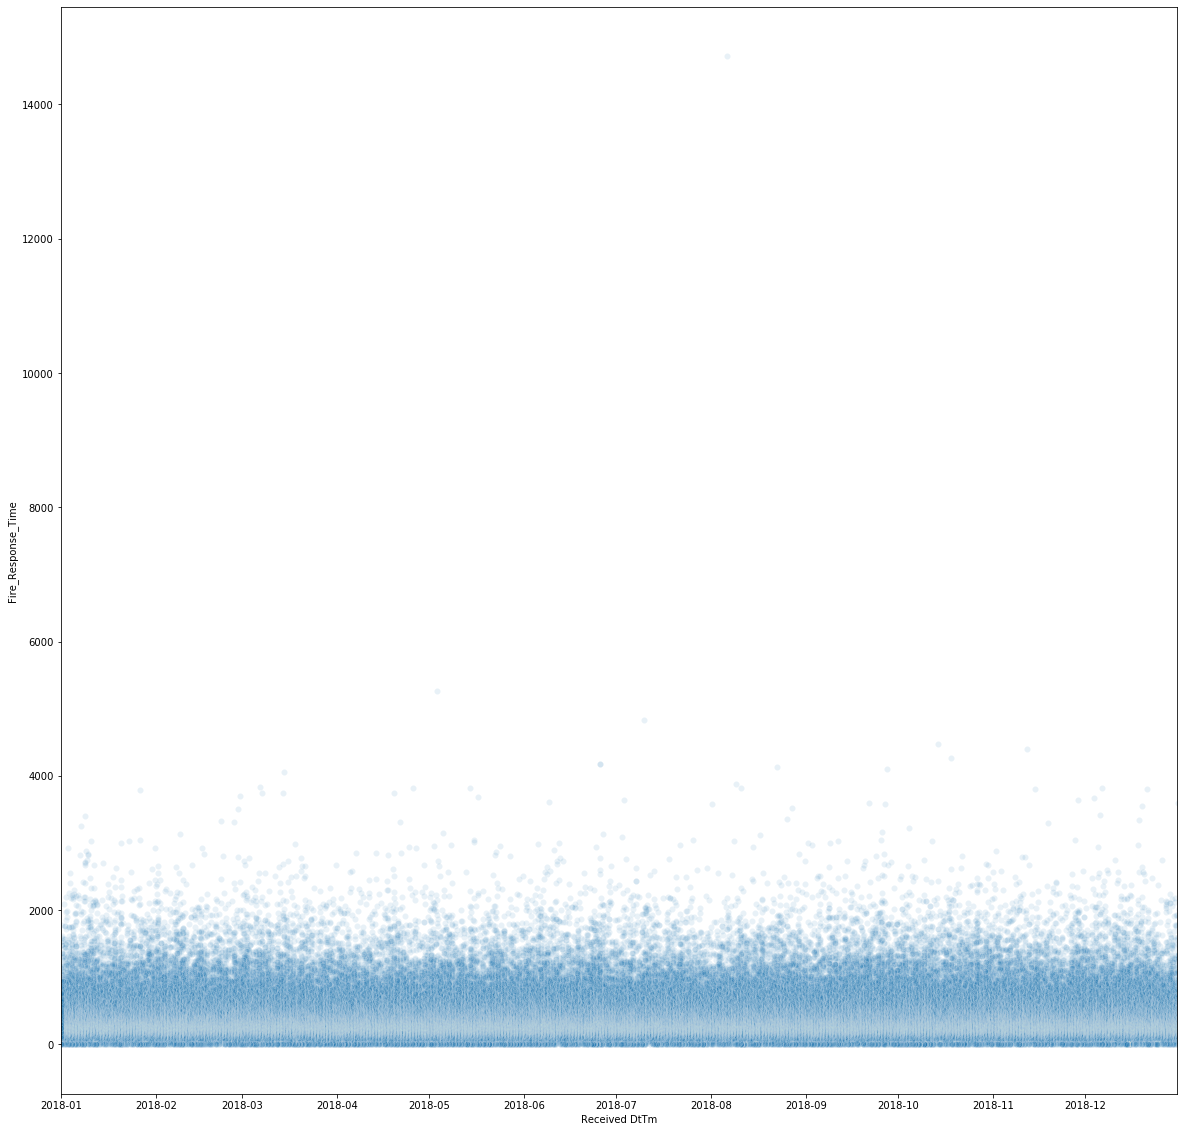

In [13]:
plt.figure(figsize=(20,20))
plt.xlim(pd.Timestamp(2018,1,1),pd.Timestamp(2018,12,31))
sns.scatterplot(Medical_2018['Received DtTm'], Medical_2018['Fire_Response_Time'],alpha=.1);

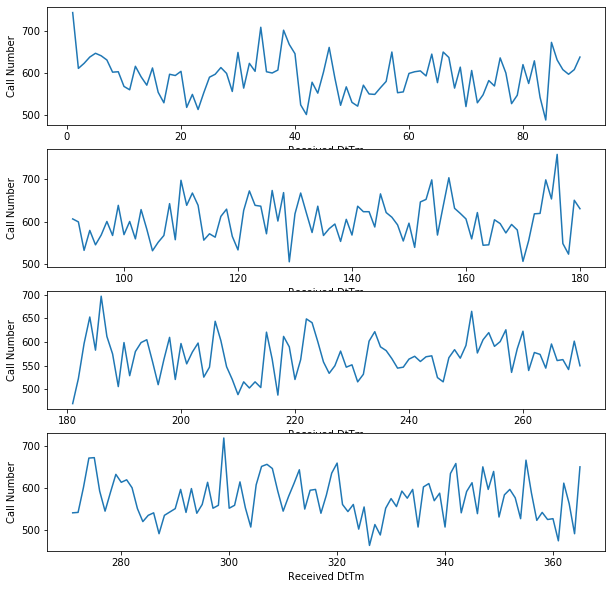

In [15]:
# Quarterly Call Volume by Day
plt.figure(figsize=(10,10))

plt.subplot(411)
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].index[:90],
 Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'][:90])

plt.subplot(412)
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].index[90:180],
 Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'][90:180])

plt.subplot(413)
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].index[180:270],
 Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'][180:270])

plt.subplot(414)
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].index[270:],
 Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'][270:]);

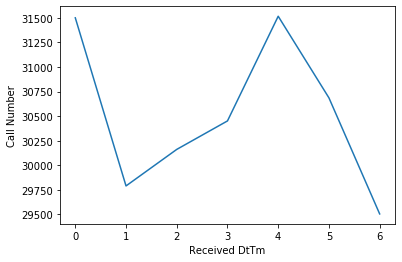

In [16]:
# Day of Week Call Volume
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.dayofweek).count()['Call Number'].index,
 Medical_2018.groupby(df['Received DtTm'].dt.dayofweek).count()['Call Number'])

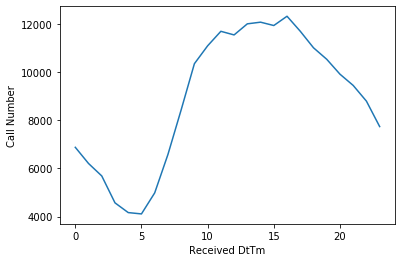

In [17]:
# Time of Day Call Volume
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.hour).count()['Call Number'].index,
 Medical_2018.groupby(df['Received DtTm'].dt.hour).count()['Call Number'])

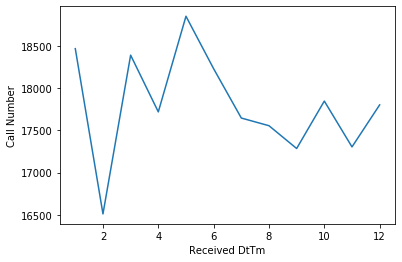

In [18]:
# Monthly Call Volume
sns.lineplot(Medical_2018.groupby(df['Received DtTm'].dt.month).count()['Call Number'].index,
 Medical_2018.groupby(df['Received DtTm'].dt.month).count()['Call Number'])

In [20]:
# Top 20 days for Call Volume
print(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].nlargest(20))
print('Mean Daily Call Volume:',Medical_2018.groupby(df['Received DtTm'].dt.dayofyear).count()['Call Number'].mean())

Received DtTm
176    759
1      745
299    719
34     710
157    704
38     703
154    699
174    699
110    698
186    697
85     674
126    674
122    673
275    672
274    671
39     669
128    669
112    668
131    668
145    666
Name: Call Number, dtype: int64
Mean Daily Call Volume: 585.2301369863013


In [21]:
top_days_2018 = list(Medical_2018.groupby(df['Received DtTm'].dt.dayofyear)\
                     .count()['Call Number']\
                     .nlargest(20)\
                     .index)

In [22]:
# High Volume Day in 2018
for day in top_days_2018:
    print(datetime.datetime(2018, 1, 1) + datetime.timedelta(day - 1))

2018-06-25 00:00:00
2018-01-01 00:00:00
2018-10-26 00:00:00
2018-02-03 00:00:00
2018-06-06 00:00:00
2018-02-07 00:00:00
2018-06-03 00:00:00
2018-06-23 00:00:00
2018-04-20 00:00:00
2018-07-05 00:00:00
2018-03-26 00:00:00
2018-05-06 00:00:00
2018-05-02 00:00:00
2018-10-02 00:00:00
2018-10-01 00:00:00
2018-02-08 00:00:00
2018-05-08 00:00:00
2018-04-22 00:00:00
2018-05-11 00:00:00
2018-05-25 00:00:00


### Changes in EMS Call Rate Over Time

In [23]:
Medical_2017 = df[(df['Call Date'].dt.year == 2017) 
                  & (df['Call Type'] == 'Medical Incident')]

In [24]:
Medical_2007 = df[(df['Call Date'].dt.year == 2007) 
                  & (df['Call Type'] == 'Medical Incident')]

In [25]:
# Call volume per person - 2017
len(Medical_2017)/884363

0.24327340696071637

In [26]:
# Call volume per person - 2007
len(Medical_2007)/758348

0.19492765854198865

In [28]:
#  2017 vs 2007 populations
884363 - 758348

126015

In [27]:
#  Change in EMS calls per population from 2007 to 2017
len(Medical_2017)/884363 - len(Medical_2007)/758348

0.04834574841872771

### Ideas list

In [29]:
# On a high volume day how are the response times

In [30]:
# look at big events and see how many 

In [31]:
# compare most dangerous car accident locations

In [32]:
# location information - what places have the highest volume (Pier 39)
# Predict many time series based on location
# I'm modeling demand to figure out where supply is needed
# Look at car accidents
# Weather data -  precip, wind, temperature, clouds,  
# maybe less suicide attempts on sunny days
# maybe more car accidents on rainy days

In [33]:
# cluster analysis of calls and compare to fire districts
# create on optimaization of where resources should be

In [34]:
# Frequent Flyers???

In [35]:
# Looking at seasonality of places in sf

### Building Hourly Call Volume Time Series Data

In [75]:
df['Hourly_DtTm'] = df['Received DtTm'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))

In [76]:
df['Q_Hour_DtTm'] = df['Received DtTm'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

In [77]:
df['Daily_DtTm'] = df['Received DtTm'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))

In [78]:
Medical_2018 = df[(df['Call Date'].dt.year == 2018) 
                  & (df['Call Type'] == 'Medical Incident')]

In [79]:
Medical_2008 = df[(df['Call Date'].dt.year == 2008) 
                  & (df['Call Type'] == 'Medical Incident')]

In [105]:
Medical_All = df[df['Call Type'] == 'Medical Incident']

In [81]:
hourly_call_volume_medical_2018 = (Medical_2018.groupby(['Hourly_DtTm','Call Number'])\
                                   .count()\
                                   .reset_index()).groupby('Hourly_DtTm').count()['Call Number']

In [82]:
hourly_call_volume_medical_2008 = (Medical_2008.groupby(['Hourly_DtTm','Call Number'])\
                                   .count()\
                                   .reset_index()).groupby('Hourly_DtTm').count()['Call Number']

In [106]:
hourly_call_volume_medical_all = (Medical_All.groupby(['Hourly_DtTm','Call Number'])\
                                  .count()\
                                  .reset_index()).groupby('Hourly_DtTm').count()['Call Number']

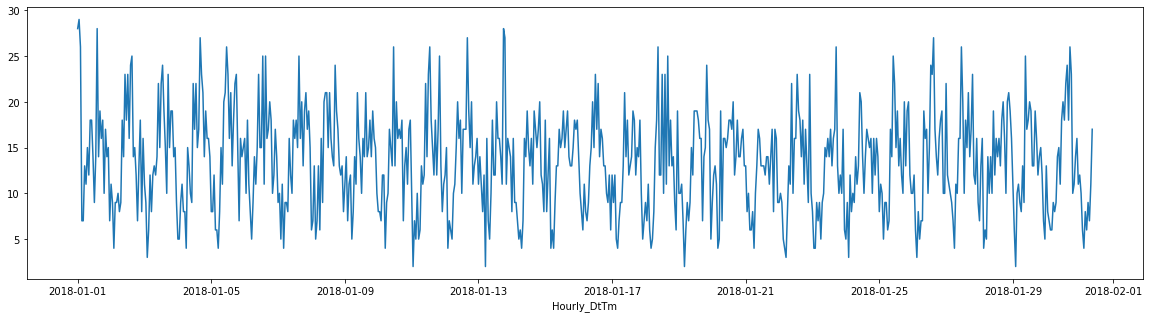

In [84]:
plt.figure(figsize=(20,5))
sns.lineplot(hourly_call_volume_medical_2018.index[:730], hourly_call_volume_medical_2018.values[:730])

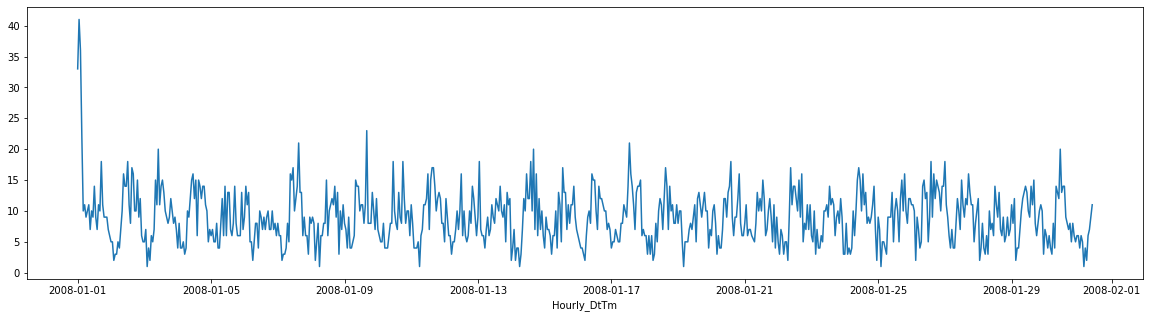

In [85]:
plt.figure(figsize=(20,5))
sns.lineplot(hourly_call_volume_medical_2008.index[:730], hourly_call_volume_medical_2008.values[:730])

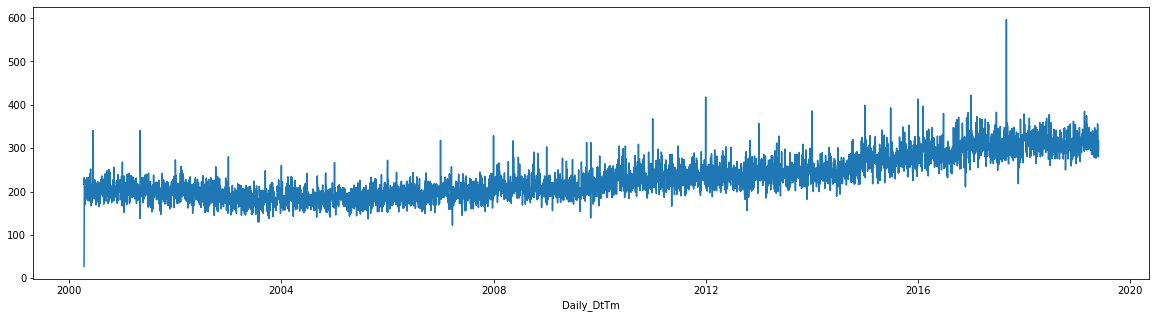

In [86]:
plt.figure(figsize=(20,5))
sns.lineplot(hourly_call_volume_medical_all.index, hourly_call_volume_medical_all.values)

In [88]:
# Pickling Call Volume 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_2018.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_2018,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_2018.pickle','rb') as f:
        hourly_call_volume_medical_2018 = pickle.load(f)

In [107]:
# Pickling All Call Volume df
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_all.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_all,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_all.pickle','rb') as f:
        hourly_call_volume_medical_all = pickle.load(f)

### Building 15 Minute Interval Units Unavailable Time Series Data

In [ ]:
# Medical_2018 = Medical_2018.sort_values(by='Received DtTm').reset_index().drop(columns=['index'])

In [63]:
# Finding average time(minutes) a unit is unavailable
((Medical_2018['Available DtTm'] - Medical_2018['Dispatch DtTm']).dt.seconds/60).describe()

count    213579.000000
mean         41.026919
std          33.621013
min           0.000000
25%          10.666667
50%          27.816667
75%          70.750000
max         366.333333
dtype: float64

In [64]:
fifteen_min_intervals_2018 = pd.date_range(start='1/1/2018', end='1/1/2019', freq='15min')

In [65]:
# Finding total unavailable units every 15 minutes in 2018
unavailable_units_15_min_int_counts = defaultdict(int)
for interval in fifteen_min_intervals_2018:
    count = len(Medical_2018[(interval > Medical_2018['Dispatch DtTm']) & (interval < Medical_2018['Available DtTm'])])
    unavailable_units_15_min_int_counts[interval] = count
    print(interval)

2018-01-01 00:00:00
2018-01-01 00:15:00
2018-01-01 00:30:00
2018-01-01 00:45:00
2018-01-01 01:00:00
2018-01-01 01:15:00
2018-01-01 01:30:00
2018-01-01 01:45:00
2018-01-01 02:00:00
2018-01-01 02:15:00
2018-01-01 02:30:00
2018-01-01 02:45:00
2018-01-01 03:00:00
2018-01-01 03:15:00
2018-01-01 03:30:00
2018-01-01 03:45:00
2018-01-01 04:00:00
2018-01-01 04:15:00
2018-01-01 04:30:00
2018-01-01 04:45:00
2018-01-01 05:00:00
2018-01-01 05:15:00
2018-01-01 05:30:00
2018-01-01 05:45:00
2018-01-01 06:00:00
2018-01-01 06:15:00
2018-01-01 06:30:00
2018-01-01 06:45:00
2018-01-01 07:00:00
2018-01-01 07:15:00
2018-01-01 07:30:00
2018-01-01 07:45:00
2018-01-01 08:00:00
2018-01-01 08:15:00
2018-01-01 08:30:00
2018-01-01 08:45:00
2018-01-01 09:00:00
2018-01-01 09:15:00
2018-01-01 09:30:00
2018-01-01 09:45:00
2018-01-01 10:00:00
2018-01-01 10:15:00
2018-01-01 10:30:00
2018-01-01 10:45:00
2018-01-01 11:00:00
2018-01-01 11:15:00
2018-01-01 11:30:00
2018-01-01 11:45:00
2018-01-01 12:00:00
2018-01-01 12:15:00


2018-01-06 04:45:00
2018-01-06 05:00:00
2018-01-06 05:15:00
2018-01-06 05:30:00
2018-01-06 05:45:00
2018-01-06 06:00:00
2018-01-06 06:15:00
2018-01-06 06:30:00
2018-01-06 06:45:00
2018-01-06 07:00:00
2018-01-06 07:15:00
2018-01-06 07:30:00
2018-01-06 07:45:00
2018-01-06 08:00:00
2018-01-06 08:15:00
2018-01-06 08:30:00
2018-01-06 08:45:00
2018-01-06 09:00:00
2018-01-06 09:15:00
2018-01-06 09:30:00
2018-01-06 09:45:00
2018-01-06 10:00:00
2018-01-06 10:15:00
2018-01-06 10:30:00
2018-01-06 10:45:00
2018-01-06 11:00:00
2018-01-06 11:15:00
2018-01-06 11:30:00
2018-01-06 11:45:00
2018-01-06 12:00:00
2018-01-06 12:15:00
2018-01-06 12:30:00
2018-01-06 12:45:00
2018-01-06 13:00:00
2018-01-06 13:15:00
2018-01-06 13:30:00
2018-01-06 13:45:00
2018-01-06 14:00:00
2018-01-06 14:15:00
2018-01-06 14:30:00
2018-01-06 14:45:00
2018-01-06 15:00:00
2018-01-06 15:15:00
2018-01-06 15:30:00
2018-01-06 15:45:00
2018-01-06 16:00:00
2018-01-06 16:15:00
2018-01-06 16:30:00
2018-01-06 16:45:00
2018-01-06 17:00:00


2018-01-11 07:15:00
2018-01-11 07:30:00
2018-01-11 07:45:00
2018-01-11 08:00:00
2018-01-11 08:15:00
2018-01-11 08:30:00
2018-01-11 08:45:00
2018-01-11 09:00:00
2018-01-11 09:15:00
2018-01-11 09:30:00
2018-01-11 09:45:00
2018-01-11 10:00:00
2018-01-11 10:15:00
2018-01-11 10:30:00
2018-01-11 10:45:00
2018-01-11 11:00:00
2018-01-11 11:15:00
2018-01-11 11:30:00
2018-01-11 11:45:00
2018-01-11 12:00:00
2018-01-11 12:15:00
2018-01-11 12:30:00
2018-01-11 12:45:00
2018-01-11 13:00:00
2018-01-11 13:15:00
2018-01-11 13:30:00
2018-01-11 13:45:00
2018-01-11 14:00:00
2018-01-11 14:15:00
2018-01-11 14:30:00
2018-01-11 14:45:00
2018-01-11 15:00:00
2018-01-11 15:15:00
2018-01-11 15:30:00
2018-01-11 15:45:00
2018-01-11 16:00:00
2018-01-11 16:15:00
2018-01-11 16:30:00
2018-01-11 16:45:00
2018-01-11 17:00:00
2018-01-11 17:15:00
2018-01-11 17:30:00
2018-01-11 17:45:00
2018-01-11 18:00:00
2018-01-11 18:15:00
2018-01-11 18:30:00
2018-01-11 18:45:00
2018-01-11 19:00:00
2018-01-11 19:15:00
2018-01-11 19:30:00


2018-01-16 09:30:00
2018-01-16 09:45:00
2018-01-16 10:00:00
2018-01-16 10:15:00
2018-01-16 10:30:00
2018-01-16 10:45:00
2018-01-16 11:00:00
2018-01-16 11:15:00
2018-01-16 11:30:00
2018-01-16 11:45:00
2018-01-16 12:00:00
2018-01-16 12:15:00
2018-01-16 12:30:00
2018-01-16 12:45:00
2018-01-16 13:00:00
2018-01-16 13:15:00
2018-01-16 13:30:00
2018-01-16 13:45:00
2018-01-16 14:00:00
2018-01-16 14:15:00
2018-01-16 14:30:00
2018-01-16 14:45:00
2018-01-16 15:00:00
2018-01-16 15:15:00
2018-01-16 15:30:00
2018-01-16 15:45:00
2018-01-16 16:00:00
2018-01-16 16:15:00
2018-01-16 16:30:00
2018-01-16 16:45:00
2018-01-16 17:00:00
2018-01-16 17:15:00
2018-01-16 17:30:00
2018-01-16 17:45:00
2018-01-16 18:00:00
2018-01-16 18:15:00
2018-01-16 18:30:00
2018-01-16 18:45:00
2018-01-16 19:00:00
2018-01-16 19:15:00
2018-01-16 19:30:00
2018-01-16 19:45:00
2018-01-16 20:00:00
2018-01-16 20:15:00
2018-01-16 20:30:00
2018-01-16 20:45:00
2018-01-16 21:00:00
2018-01-16 21:15:00
2018-01-16 21:30:00
2018-01-16 21:45:00


2018-01-20 16:15:00
2018-01-20 16:30:00
2018-01-20 16:45:00
2018-01-20 17:00:00
2018-01-20 17:15:00
2018-01-20 17:30:00
2018-01-20 17:45:00
2018-01-20 18:00:00
2018-01-20 18:15:00
2018-01-20 18:30:00
2018-01-20 18:45:00
2018-01-20 19:00:00
2018-01-20 19:15:00
2018-01-20 19:30:00
2018-01-20 19:45:00
2018-01-20 20:00:00
2018-01-20 20:15:00
2018-01-20 20:30:00
2018-01-20 20:45:00
2018-01-20 21:00:00
2018-01-20 21:15:00
2018-01-20 21:30:00
2018-01-20 21:45:00
2018-01-20 22:00:00
2018-01-20 22:15:00
2018-01-20 22:30:00
2018-01-20 22:45:00
2018-01-20 23:00:00
2018-01-20 23:15:00
2018-01-20 23:30:00
2018-01-20 23:45:00
2018-01-21 00:00:00
2018-01-21 00:15:00
2018-01-21 00:30:00
2018-01-21 00:45:00
2018-01-21 01:00:00
2018-01-21 01:15:00
2018-01-21 01:30:00
2018-01-21 01:45:00
2018-01-21 02:00:00
2018-01-21 02:15:00
2018-01-21 02:30:00
2018-01-21 02:45:00
2018-01-21 03:00:00
2018-01-21 03:15:00
2018-01-21 03:30:00
2018-01-21 03:45:00
2018-01-21 04:00:00
2018-01-21 04:15:00
2018-01-21 04:30:00


2018-01-26 00:30:00
2018-01-26 00:45:00
2018-01-26 01:00:00
2018-01-26 01:15:00
2018-01-26 01:30:00
2018-01-26 01:45:00
2018-01-26 02:00:00
2018-01-26 02:15:00
2018-01-26 02:30:00
2018-01-26 02:45:00
2018-01-26 03:00:00
2018-01-26 03:15:00
2018-01-26 03:30:00
2018-01-26 03:45:00
2018-01-26 04:00:00
2018-01-26 04:15:00
2018-01-26 04:30:00
2018-01-26 04:45:00
2018-01-26 05:00:00
2018-01-26 05:15:00
2018-01-26 05:30:00
2018-01-26 05:45:00
2018-01-26 06:00:00
2018-01-26 06:15:00
2018-01-26 06:30:00
2018-01-26 06:45:00
2018-01-26 07:00:00
2018-01-26 07:15:00
2018-01-26 07:30:00
2018-01-26 07:45:00
2018-01-26 08:00:00
2018-01-26 08:15:00
2018-01-26 08:30:00
2018-01-26 08:45:00
2018-01-26 09:00:00
2018-01-26 09:15:00
2018-01-26 09:30:00
2018-01-26 09:45:00
2018-01-26 10:00:00
2018-01-26 10:15:00
2018-01-26 10:30:00
2018-01-26 10:45:00
2018-01-26 11:00:00
2018-01-26 11:15:00
2018-01-26 11:30:00
2018-01-26 11:45:00
2018-01-26 12:00:00
2018-01-26 12:15:00
2018-01-26 12:30:00
2018-01-26 12:45:00


2018-01-31 09:30:00
2018-01-31 09:45:00
2018-01-31 10:00:00
2018-01-31 10:15:00
2018-01-31 10:30:00
2018-01-31 10:45:00
2018-01-31 11:00:00
2018-01-31 11:15:00
2018-01-31 11:30:00
2018-01-31 11:45:00
2018-01-31 12:00:00
2018-01-31 12:15:00
2018-01-31 12:30:00
2018-01-31 12:45:00
2018-01-31 13:00:00
2018-01-31 13:15:00
2018-01-31 13:30:00
2018-01-31 13:45:00
2018-01-31 14:00:00
2018-01-31 14:15:00
2018-01-31 14:30:00
2018-01-31 14:45:00
2018-01-31 15:00:00
2018-01-31 15:15:00
2018-01-31 15:30:00
2018-01-31 15:45:00
2018-01-31 16:00:00
2018-01-31 16:15:00
2018-01-31 16:30:00
2018-01-31 16:45:00
2018-01-31 17:00:00
2018-01-31 17:15:00
2018-01-31 17:30:00
2018-01-31 17:45:00
2018-01-31 18:00:00
2018-01-31 18:15:00
2018-01-31 18:30:00
2018-01-31 18:45:00
2018-01-31 19:00:00
2018-01-31 19:15:00
2018-01-31 19:30:00
2018-01-31 19:45:00
2018-01-31 20:00:00
2018-01-31 20:15:00
2018-01-31 20:30:00
2018-01-31 20:45:00
2018-01-31 21:00:00
2018-01-31 21:15:00
2018-01-31 21:30:00
2018-01-31 21:45:00


2018-02-05 14:15:00
2018-02-05 14:30:00
2018-02-05 14:45:00
2018-02-05 15:00:00
2018-02-05 15:15:00
2018-02-05 15:30:00
2018-02-05 15:45:00
2018-02-05 16:00:00
2018-02-05 16:15:00
2018-02-05 16:30:00
2018-02-05 16:45:00
2018-02-05 17:00:00
2018-02-05 17:15:00
2018-02-05 17:30:00
2018-02-05 17:45:00
2018-02-05 18:00:00
2018-02-05 18:15:00
2018-02-05 18:30:00
2018-02-05 18:45:00
2018-02-05 19:00:00
2018-02-05 19:15:00
2018-02-05 19:30:00
2018-02-05 19:45:00
2018-02-05 20:00:00
2018-02-05 20:15:00
2018-02-05 20:30:00
2018-02-05 20:45:00
2018-02-05 21:00:00
2018-02-05 21:15:00
2018-02-05 21:30:00
2018-02-05 21:45:00
2018-02-05 22:00:00
2018-02-05 22:15:00
2018-02-05 22:30:00
2018-02-05 22:45:00
2018-02-05 23:00:00
2018-02-05 23:15:00
2018-02-05 23:30:00
2018-02-05 23:45:00
2018-02-06 00:00:00
2018-02-06 00:15:00
2018-02-06 00:30:00
2018-02-06 00:45:00
2018-02-06 01:00:00
2018-02-06 01:15:00
2018-02-06 01:30:00
2018-02-06 01:45:00
2018-02-06 02:00:00
2018-02-06 02:15:00
2018-02-06 02:30:00


2018-02-09 23:00:00
2018-02-09 23:15:00
2018-02-09 23:30:00
2018-02-09 23:45:00
2018-02-10 00:00:00
2018-02-10 00:15:00
2018-02-10 00:30:00
2018-02-10 00:45:00
2018-02-10 01:00:00
2018-02-10 01:15:00
2018-02-10 01:30:00
2018-02-10 01:45:00
2018-02-10 02:00:00
2018-02-10 02:15:00
2018-02-10 02:30:00
2018-02-10 02:45:00
2018-02-10 03:00:00
2018-02-10 03:15:00
2018-02-10 03:30:00
2018-02-10 03:45:00
2018-02-10 04:00:00
2018-02-10 04:15:00
2018-02-10 04:30:00
2018-02-10 04:45:00
2018-02-10 05:00:00
2018-02-10 05:15:00
2018-02-10 05:30:00
2018-02-10 05:45:00
2018-02-10 06:00:00
2018-02-10 06:15:00
2018-02-10 06:30:00
2018-02-10 06:45:00
2018-02-10 07:00:00
2018-02-10 07:15:00
2018-02-10 07:30:00
2018-02-10 07:45:00
2018-02-10 08:00:00
2018-02-10 08:15:00
2018-02-10 08:30:00
2018-02-10 08:45:00
2018-02-10 09:00:00
2018-02-10 09:15:00
2018-02-10 09:30:00
2018-02-10 09:45:00
2018-02-10 10:00:00
2018-02-10 10:15:00
2018-02-10 10:30:00
2018-02-10 10:45:00
2018-02-10 11:00:00
2018-02-10 11:15:00


2018-02-15 08:45:00
2018-02-15 09:00:00
2018-02-15 09:15:00
2018-02-15 09:30:00
2018-02-15 09:45:00
2018-02-15 10:00:00
2018-02-15 10:15:00
2018-02-15 10:30:00
2018-02-15 10:45:00
2018-02-15 11:00:00
2018-02-15 11:15:00
2018-02-15 11:30:00
2018-02-15 11:45:00
2018-02-15 12:00:00
2018-02-15 12:15:00
2018-02-15 12:30:00
2018-02-15 12:45:00
2018-02-15 13:00:00
2018-02-15 13:15:00
2018-02-15 13:30:00
2018-02-15 13:45:00
2018-02-15 14:00:00
2018-02-15 14:15:00
2018-02-15 14:30:00
2018-02-15 14:45:00
2018-02-15 15:00:00
2018-02-15 15:15:00
2018-02-15 15:30:00
2018-02-15 15:45:00
2018-02-15 16:00:00
2018-02-15 16:15:00
2018-02-15 16:30:00
2018-02-15 16:45:00
2018-02-15 17:00:00
2018-02-15 17:15:00
2018-02-15 17:30:00
2018-02-15 17:45:00
2018-02-15 18:00:00
2018-02-15 18:15:00
2018-02-15 18:30:00
2018-02-15 18:45:00
2018-02-15 19:00:00
2018-02-15 19:15:00
2018-02-15 19:30:00
2018-02-15 19:45:00
2018-02-15 20:00:00
2018-02-15 20:15:00
2018-02-15 20:30:00
2018-02-15 20:45:00
2018-02-15 21:00:00


2018-02-19 22:15:00
2018-02-19 22:30:00
2018-02-19 22:45:00
2018-02-19 23:00:00
2018-02-19 23:15:00
2018-02-19 23:30:00
2018-02-19 23:45:00
2018-02-20 00:00:00
2018-02-20 00:15:00
2018-02-20 00:30:00
2018-02-20 00:45:00
2018-02-20 01:00:00
2018-02-20 01:15:00
2018-02-20 01:30:00
2018-02-20 01:45:00
2018-02-20 02:00:00
2018-02-20 02:15:00
2018-02-20 02:30:00
2018-02-20 02:45:00
2018-02-20 03:00:00
2018-02-20 03:15:00
2018-02-20 03:30:00
2018-02-20 03:45:00
2018-02-20 04:00:00
2018-02-20 04:15:00
2018-02-20 04:30:00
2018-02-20 04:45:00
2018-02-20 05:00:00
2018-02-20 05:15:00
2018-02-20 05:30:00
2018-02-20 05:45:00
2018-02-20 06:00:00
2018-02-20 06:15:00
2018-02-20 06:30:00
2018-02-20 06:45:00
2018-02-20 07:00:00
2018-02-20 07:15:00
2018-02-20 07:30:00
2018-02-20 07:45:00
2018-02-20 08:00:00
2018-02-20 08:15:00
2018-02-20 08:30:00
2018-02-20 08:45:00
2018-02-20 09:00:00
2018-02-20 09:15:00
2018-02-20 09:30:00
2018-02-20 09:45:00
2018-02-20 10:00:00
2018-02-20 10:15:00
2018-02-20 10:30:00


2018-02-24 12:45:00
2018-02-24 13:00:00
2018-02-24 13:15:00
2018-02-24 13:30:00
2018-02-24 13:45:00
2018-02-24 14:00:00
2018-02-24 14:15:00
2018-02-24 14:30:00
2018-02-24 14:45:00
2018-02-24 15:00:00
2018-02-24 15:15:00
2018-02-24 15:30:00
2018-02-24 15:45:00
2018-02-24 16:00:00
2018-02-24 16:15:00
2018-02-24 16:30:00
2018-02-24 16:45:00
2018-02-24 17:00:00
2018-02-24 17:15:00
2018-02-24 17:30:00
2018-02-24 17:45:00
2018-02-24 18:00:00
2018-02-24 18:15:00
2018-02-24 18:30:00
2018-02-24 18:45:00
2018-02-24 19:00:00
2018-02-24 19:15:00
2018-02-24 19:30:00
2018-02-24 19:45:00
2018-02-24 20:00:00
2018-02-24 20:15:00
2018-02-24 20:30:00
2018-02-24 20:45:00
2018-02-24 21:00:00
2018-02-24 21:15:00
2018-02-24 21:30:00
2018-02-24 21:45:00
2018-02-24 22:00:00
2018-02-24 22:15:00
2018-02-24 22:30:00
2018-02-24 22:45:00
2018-02-24 23:00:00
2018-02-24 23:15:00
2018-02-24 23:30:00
2018-02-24 23:45:00
2018-02-25 00:00:00
2018-02-25 00:15:00
2018-02-25 00:30:00
2018-02-25 00:45:00
2018-02-25 01:00:00


2018-03-01 03:15:00
2018-03-01 03:30:00
2018-03-01 03:45:00
2018-03-01 04:00:00
2018-03-01 04:15:00
2018-03-01 04:30:00
2018-03-01 04:45:00
2018-03-01 05:00:00
2018-03-01 05:15:00
2018-03-01 05:30:00
2018-03-01 05:45:00
2018-03-01 06:00:00
2018-03-01 06:15:00
2018-03-01 06:30:00
2018-03-01 06:45:00
2018-03-01 07:00:00
2018-03-01 07:15:00
2018-03-01 07:30:00
2018-03-01 07:45:00
2018-03-01 08:00:00
2018-03-01 08:15:00
2018-03-01 08:30:00
2018-03-01 08:45:00
2018-03-01 09:00:00
2018-03-01 09:15:00
2018-03-01 09:30:00
2018-03-01 09:45:00
2018-03-01 10:00:00
2018-03-01 10:15:00
2018-03-01 10:30:00
2018-03-01 10:45:00
2018-03-01 11:00:00
2018-03-01 11:15:00
2018-03-01 11:30:00
2018-03-01 11:45:00
2018-03-01 12:00:00
2018-03-01 12:15:00
2018-03-01 12:30:00
2018-03-01 12:45:00
2018-03-01 13:00:00
2018-03-01 13:15:00
2018-03-01 13:30:00
2018-03-01 13:45:00
2018-03-01 14:00:00
2018-03-01 14:15:00
2018-03-01 14:30:00
2018-03-01 14:45:00
2018-03-01 15:00:00
2018-03-01 15:15:00
2018-03-01 15:30:00


2018-03-06 10:30:00
2018-03-06 10:45:00
2018-03-06 11:00:00
2018-03-06 11:15:00
2018-03-06 11:30:00
2018-03-06 11:45:00
2018-03-06 12:00:00
2018-03-06 12:15:00
2018-03-06 12:30:00
2018-03-06 12:45:00
2018-03-06 13:00:00
2018-03-06 13:15:00
2018-03-06 13:30:00
2018-03-06 13:45:00
2018-03-06 14:00:00
2018-03-06 14:15:00
2018-03-06 14:30:00
2018-03-06 14:45:00
2018-03-06 15:00:00
2018-03-06 15:15:00
2018-03-06 15:30:00
2018-03-06 15:45:00
2018-03-06 16:00:00
2018-03-06 16:15:00
2018-03-06 16:30:00
2018-03-06 16:45:00
2018-03-06 17:00:00
2018-03-06 17:15:00
2018-03-06 17:30:00
2018-03-06 17:45:00
2018-03-06 18:00:00
2018-03-06 18:15:00
2018-03-06 18:30:00
2018-03-06 18:45:00
2018-03-06 19:00:00
2018-03-06 19:15:00
2018-03-06 19:30:00
2018-03-06 19:45:00
2018-03-06 20:00:00
2018-03-06 20:15:00
2018-03-06 20:30:00
2018-03-06 20:45:00
2018-03-06 21:00:00
2018-03-06 21:15:00
2018-03-06 21:30:00
2018-03-06 21:45:00
2018-03-06 22:00:00
2018-03-06 22:15:00
2018-03-06 22:30:00
2018-03-06 22:45:00


2018-03-11 13:15:00
2018-03-11 13:30:00
2018-03-11 13:45:00
2018-03-11 14:00:00
2018-03-11 14:15:00
2018-03-11 14:30:00
2018-03-11 14:45:00
2018-03-11 15:00:00
2018-03-11 15:15:00
2018-03-11 15:30:00
2018-03-11 15:45:00
2018-03-11 16:00:00
2018-03-11 16:15:00
2018-03-11 16:30:00
2018-03-11 16:45:00
2018-03-11 17:00:00
2018-03-11 17:15:00
2018-03-11 17:30:00
2018-03-11 17:45:00
2018-03-11 18:00:00
2018-03-11 18:15:00
2018-03-11 18:30:00
2018-03-11 18:45:00
2018-03-11 19:00:00
2018-03-11 19:15:00
2018-03-11 19:30:00
2018-03-11 19:45:00
2018-03-11 20:00:00
2018-03-11 20:15:00
2018-03-11 20:30:00
2018-03-11 20:45:00
2018-03-11 21:00:00
2018-03-11 21:15:00
2018-03-11 21:30:00
2018-03-11 21:45:00
2018-03-11 22:00:00
2018-03-11 22:15:00
2018-03-11 22:30:00
2018-03-11 22:45:00
2018-03-11 23:00:00
2018-03-11 23:15:00
2018-03-11 23:30:00
2018-03-11 23:45:00
2018-03-12 00:00:00
2018-03-12 00:15:00
2018-03-12 00:30:00
2018-03-12 00:45:00
2018-03-12 01:00:00
2018-03-12 01:15:00
2018-03-12 01:30:00


2018-03-16 14:15:00
2018-03-16 14:30:00
2018-03-16 14:45:00
2018-03-16 15:00:00
2018-03-16 15:15:00
2018-03-16 15:30:00
2018-03-16 15:45:00
2018-03-16 16:00:00
2018-03-16 16:15:00
2018-03-16 16:30:00
2018-03-16 16:45:00
2018-03-16 17:00:00
2018-03-16 17:15:00
2018-03-16 17:30:00
2018-03-16 17:45:00
2018-03-16 18:00:00
2018-03-16 18:15:00
2018-03-16 18:30:00
2018-03-16 18:45:00
2018-03-16 19:00:00
2018-03-16 19:15:00
2018-03-16 19:30:00
2018-03-16 19:45:00
2018-03-16 20:00:00
2018-03-16 20:15:00
2018-03-16 20:30:00
2018-03-16 20:45:00
2018-03-16 21:00:00
2018-03-16 21:15:00
2018-03-16 21:30:00
2018-03-16 21:45:00
2018-03-16 22:00:00
2018-03-16 22:15:00
2018-03-16 22:30:00
2018-03-16 22:45:00
2018-03-16 23:00:00
2018-03-16 23:15:00
2018-03-16 23:30:00
2018-03-16 23:45:00
2018-03-17 00:00:00
2018-03-17 00:15:00
2018-03-17 00:30:00
2018-03-17 00:45:00
2018-03-17 01:00:00
2018-03-17 01:15:00
2018-03-17 01:30:00
2018-03-17 01:45:00
2018-03-17 02:00:00
2018-03-17 02:15:00
2018-03-17 02:30:00


2018-03-21 02:45:00
2018-03-21 03:00:00
2018-03-21 03:15:00
2018-03-21 03:30:00
2018-03-21 03:45:00
2018-03-21 04:00:00
2018-03-21 04:15:00
2018-03-21 04:30:00
2018-03-21 04:45:00
2018-03-21 05:00:00
2018-03-21 05:15:00
2018-03-21 05:30:00
2018-03-21 05:45:00
2018-03-21 06:00:00
2018-03-21 06:15:00
2018-03-21 06:30:00
2018-03-21 06:45:00
2018-03-21 07:00:00
2018-03-21 07:15:00
2018-03-21 07:30:00
2018-03-21 07:45:00
2018-03-21 08:00:00
2018-03-21 08:15:00
2018-03-21 08:30:00
2018-03-21 08:45:00
2018-03-21 09:00:00
2018-03-21 09:15:00
2018-03-21 09:30:00
2018-03-21 09:45:00
2018-03-21 10:00:00
2018-03-21 10:15:00
2018-03-21 10:30:00
2018-03-21 10:45:00
2018-03-21 11:00:00
2018-03-21 11:15:00
2018-03-21 11:30:00
2018-03-21 11:45:00
2018-03-21 12:00:00
2018-03-21 12:15:00
2018-03-21 12:30:00
2018-03-21 12:45:00
2018-03-21 13:00:00
2018-03-21 13:15:00
2018-03-21 13:30:00
2018-03-21 13:45:00
2018-03-21 14:00:00
2018-03-21 14:15:00
2018-03-21 14:30:00
2018-03-21 14:45:00
2018-03-21 15:00:00


2018-03-25 14:00:00
2018-03-25 14:15:00
2018-03-25 14:30:00
2018-03-25 14:45:00
2018-03-25 15:00:00
2018-03-25 15:15:00
2018-03-25 15:30:00
2018-03-25 15:45:00
2018-03-25 16:00:00
2018-03-25 16:15:00
2018-03-25 16:30:00
2018-03-25 16:45:00
2018-03-25 17:00:00
2018-03-25 17:15:00
2018-03-25 17:30:00
2018-03-25 17:45:00
2018-03-25 18:00:00
2018-03-25 18:15:00
2018-03-25 18:30:00
2018-03-25 18:45:00
2018-03-25 19:00:00
2018-03-25 19:15:00
2018-03-25 19:30:00
2018-03-25 19:45:00
2018-03-25 20:00:00
2018-03-25 20:15:00
2018-03-25 20:30:00
2018-03-25 20:45:00
2018-03-25 21:00:00
2018-03-25 21:15:00
2018-03-25 21:30:00
2018-03-25 21:45:00
2018-03-25 22:00:00
2018-03-25 22:15:00
2018-03-25 22:30:00
2018-03-25 22:45:00
2018-03-25 23:00:00
2018-03-25 23:15:00
2018-03-25 23:30:00
2018-03-25 23:45:00
2018-03-26 00:00:00
2018-03-26 00:15:00
2018-03-26 00:30:00
2018-03-26 00:45:00
2018-03-26 01:00:00
2018-03-26 01:15:00
2018-03-26 01:30:00
2018-03-26 01:45:00
2018-03-26 02:00:00
2018-03-26 02:15:00


2018-03-30 04:15:00
2018-03-30 04:30:00
2018-03-30 04:45:00
2018-03-30 05:00:00
2018-03-30 05:15:00
2018-03-30 05:30:00
2018-03-30 05:45:00
2018-03-30 06:00:00
2018-03-30 06:15:00
2018-03-30 06:30:00
2018-03-30 06:45:00
2018-03-30 07:00:00
2018-03-30 07:15:00
2018-03-30 07:30:00
2018-03-30 07:45:00
2018-03-30 08:00:00
2018-03-30 08:15:00
2018-03-30 08:30:00
2018-03-30 08:45:00
2018-03-30 09:00:00
2018-03-30 09:15:00
2018-03-30 09:30:00
2018-03-30 09:45:00
2018-03-30 10:00:00
2018-03-30 10:15:00
2018-03-30 10:30:00
2018-03-30 10:45:00
2018-03-30 11:00:00
2018-03-30 11:15:00
2018-03-30 11:30:00
2018-03-30 11:45:00
2018-03-30 12:00:00
2018-03-30 12:15:00
2018-03-30 12:30:00
2018-03-30 12:45:00
2018-03-30 13:00:00
2018-03-30 13:15:00
2018-03-30 13:30:00
2018-03-30 13:45:00
2018-03-30 14:00:00
2018-03-30 14:15:00
2018-03-30 14:30:00
2018-03-30 14:45:00
2018-03-30 15:00:00
2018-03-30 15:15:00
2018-03-30 15:30:00
2018-03-30 15:45:00
2018-03-30 16:00:00
2018-03-30 16:15:00
2018-03-30 16:30:00


2018-04-03 19:15:00
2018-04-03 19:30:00
2018-04-03 19:45:00
2018-04-03 20:00:00
2018-04-03 20:15:00
2018-04-03 20:30:00
2018-04-03 20:45:00
2018-04-03 21:00:00
2018-04-03 21:15:00
2018-04-03 21:30:00
2018-04-03 21:45:00
2018-04-03 22:00:00
2018-04-03 22:15:00
2018-04-03 22:30:00
2018-04-03 22:45:00
2018-04-03 23:00:00
2018-04-03 23:15:00
2018-04-03 23:30:00
2018-04-03 23:45:00
2018-04-04 00:00:00
2018-04-04 00:15:00
2018-04-04 00:30:00
2018-04-04 00:45:00
2018-04-04 01:00:00
2018-04-04 01:15:00
2018-04-04 01:30:00
2018-04-04 01:45:00
2018-04-04 02:00:00
2018-04-04 02:15:00
2018-04-04 02:30:00
2018-04-04 02:45:00
2018-04-04 03:00:00
2018-04-04 03:15:00
2018-04-04 03:30:00
2018-04-04 03:45:00
2018-04-04 04:00:00
2018-04-04 04:15:00
2018-04-04 04:30:00
2018-04-04 04:45:00
2018-04-04 05:00:00
2018-04-04 05:15:00
2018-04-04 05:30:00
2018-04-04 05:45:00
2018-04-04 06:00:00
2018-04-04 06:15:00
2018-04-04 06:30:00
2018-04-04 06:45:00
2018-04-04 07:00:00
2018-04-04 07:15:00
2018-04-04 07:30:00


2018-04-08 07:30:00
2018-04-08 07:45:00
2018-04-08 08:00:00
2018-04-08 08:15:00
2018-04-08 08:30:00
2018-04-08 08:45:00
2018-04-08 09:00:00
2018-04-08 09:15:00
2018-04-08 09:30:00
2018-04-08 09:45:00
2018-04-08 10:00:00
2018-04-08 10:15:00
2018-04-08 10:30:00
2018-04-08 10:45:00
2018-04-08 11:00:00
2018-04-08 11:15:00
2018-04-08 11:30:00
2018-04-08 11:45:00
2018-04-08 12:00:00
2018-04-08 12:15:00
2018-04-08 12:30:00
2018-04-08 12:45:00
2018-04-08 13:00:00
2018-04-08 13:15:00
2018-04-08 13:30:00
2018-04-08 13:45:00
2018-04-08 14:00:00
2018-04-08 14:15:00
2018-04-08 14:30:00
2018-04-08 14:45:00
2018-04-08 15:00:00
2018-04-08 15:15:00
2018-04-08 15:30:00
2018-04-08 15:45:00
2018-04-08 16:00:00
2018-04-08 16:15:00
2018-04-08 16:30:00
2018-04-08 16:45:00
2018-04-08 17:00:00
2018-04-08 17:15:00
2018-04-08 17:30:00
2018-04-08 17:45:00
2018-04-08 18:00:00
2018-04-08 18:15:00
2018-04-08 18:30:00
2018-04-08 18:45:00
2018-04-08 19:00:00
2018-04-08 19:15:00
2018-04-08 19:30:00
2018-04-08 19:45:00


2018-04-12 15:15:00
2018-04-12 15:30:00
2018-04-12 15:45:00
2018-04-12 16:00:00
2018-04-12 16:15:00
2018-04-12 16:30:00
2018-04-12 16:45:00
2018-04-12 17:00:00
2018-04-12 17:15:00
2018-04-12 17:30:00
2018-04-12 17:45:00
2018-04-12 18:00:00
2018-04-12 18:15:00
2018-04-12 18:30:00
2018-04-12 18:45:00
2018-04-12 19:00:00
2018-04-12 19:15:00
2018-04-12 19:30:00
2018-04-12 19:45:00
2018-04-12 20:00:00
2018-04-12 20:15:00
2018-04-12 20:30:00
2018-04-12 20:45:00
2018-04-12 21:00:00
2018-04-12 21:15:00
2018-04-12 21:30:00
2018-04-12 21:45:00
2018-04-12 22:00:00
2018-04-12 22:15:00
2018-04-12 22:30:00
2018-04-12 22:45:00
2018-04-12 23:00:00
2018-04-12 23:15:00
2018-04-12 23:30:00
2018-04-12 23:45:00
2018-04-13 00:00:00
2018-04-13 00:15:00
2018-04-13 00:30:00
2018-04-13 00:45:00
2018-04-13 01:00:00
2018-04-13 01:15:00
2018-04-13 01:30:00
2018-04-13 01:45:00
2018-04-13 02:00:00
2018-04-13 02:15:00
2018-04-13 02:30:00
2018-04-13 02:45:00
2018-04-13 03:00:00
2018-04-13 03:15:00
2018-04-13 03:30:00


2018-04-17 21:00:00
2018-04-17 21:15:00
2018-04-17 21:30:00
2018-04-17 21:45:00
2018-04-17 22:00:00
2018-04-17 22:15:00
2018-04-17 22:30:00
2018-04-17 22:45:00
2018-04-17 23:00:00
2018-04-17 23:15:00
2018-04-17 23:30:00
2018-04-17 23:45:00
2018-04-18 00:00:00
2018-04-18 00:15:00
2018-04-18 00:30:00
2018-04-18 00:45:00
2018-04-18 01:00:00
2018-04-18 01:15:00
2018-04-18 01:30:00
2018-04-18 01:45:00
2018-04-18 02:00:00
2018-04-18 02:15:00
2018-04-18 02:30:00
2018-04-18 02:45:00
2018-04-18 03:00:00
2018-04-18 03:15:00
2018-04-18 03:30:00
2018-04-18 03:45:00
2018-04-18 04:00:00
2018-04-18 04:15:00
2018-04-18 04:30:00
2018-04-18 04:45:00
2018-04-18 05:00:00
2018-04-18 05:15:00
2018-04-18 05:30:00
2018-04-18 05:45:00
2018-04-18 06:00:00
2018-04-18 06:15:00
2018-04-18 06:30:00
2018-04-18 06:45:00
2018-04-18 07:00:00
2018-04-18 07:15:00
2018-04-18 07:30:00
2018-04-18 07:45:00
2018-04-18 08:00:00
2018-04-18 08:15:00
2018-04-18 08:30:00
2018-04-18 08:45:00
2018-04-18 09:00:00
2018-04-18 09:15:00


2018-04-23 02:15:00
2018-04-23 02:30:00
2018-04-23 02:45:00
2018-04-23 03:00:00
2018-04-23 03:15:00
2018-04-23 03:30:00
2018-04-23 03:45:00
2018-04-23 04:00:00
2018-04-23 04:15:00
2018-04-23 04:30:00
2018-04-23 04:45:00
2018-04-23 05:00:00
2018-04-23 05:15:00
2018-04-23 05:30:00
2018-04-23 05:45:00
2018-04-23 06:00:00
2018-04-23 06:15:00
2018-04-23 06:30:00
2018-04-23 06:45:00
2018-04-23 07:00:00
2018-04-23 07:15:00
2018-04-23 07:30:00
2018-04-23 07:45:00
2018-04-23 08:00:00
2018-04-23 08:15:00
2018-04-23 08:30:00
2018-04-23 08:45:00
2018-04-23 09:00:00
2018-04-23 09:15:00
2018-04-23 09:30:00
2018-04-23 09:45:00
2018-04-23 10:00:00
2018-04-23 10:15:00
2018-04-23 10:30:00
2018-04-23 10:45:00
2018-04-23 11:00:00
2018-04-23 11:15:00
2018-04-23 11:30:00
2018-04-23 11:45:00
2018-04-23 12:00:00
2018-04-23 12:15:00
2018-04-23 12:30:00
2018-04-23 12:45:00
2018-04-23 13:00:00
2018-04-23 13:15:00
2018-04-23 13:30:00
2018-04-23 13:45:00
2018-04-23 14:00:00
2018-04-23 14:15:00
2018-04-23 14:30:00


2018-04-27 09:45:00
2018-04-27 10:00:00
2018-04-27 10:15:00
2018-04-27 10:30:00
2018-04-27 10:45:00
2018-04-27 11:00:00
2018-04-27 11:15:00
2018-04-27 11:30:00
2018-04-27 11:45:00
2018-04-27 12:00:00
2018-04-27 12:15:00
2018-04-27 12:30:00
2018-04-27 12:45:00
2018-04-27 13:00:00
2018-04-27 13:15:00
2018-04-27 13:30:00
2018-04-27 13:45:00
2018-04-27 14:00:00
2018-04-27 14:15:00
2018-04-27 14:30:00
2018-04-27 14:45:00
2018-04-27 15:00:00
2018-04-27 15:15:00
2018-04-27 15:30:00
2018-04-27 15:45:00
2018-04-27 16:00:00
2018-04-27 16:15:00
2018-04-27 16:30:00
2018-04-27 16:45:00
2018-04-27 17:00:00
2018-04-27 17:15:00
2018-04-27 17:30:00
2018-04-27 17:45:00
2018-04-27 18:00:00
2018-04-27 18:15:00
2018-04-27 18:30:00
2018-04-27 18:45:00
2018-04-27 19:00:00
2018-04-27 19:15:00
2018-04-27 19:30:00
2018-04-27 19:45:00
2018-04-27 20:00:00
2018-04-27 20:15:00
2018-04-27 20:30:00
2018-04-27 20:45:00
2018-04-27 21:00:00
2018-04-27 21:15:00
2018-04-27 21:30:00
2018-04-27 21:45:00
2018-04-27 22:00:00


2018-05-01 21:00:00
2018-05-01 21:15:00
2018-05-01 21:30:00
2018-05-01 21:45:00
2018-05-01 22:00:00
2018-05-01 22:15:00
2018-05-01 22:30:00
2018-05-01 22:45:00
2018-05-01 23:00:00
2018-05-01 23:15:00
2018-05-01 23:30:00
2018-05-01 23:45:00
2018-05-02 00:00:00
2018-05-02 00:15:00
2018-05-02 00:30:00
2018-05-02 00:45:00
2018-05-02 01:00:00
2018-05-02 01:15:00
2018-05-02 01:30:00
2018-05-02 01:45:00
2018-05-02 02:00:00
2018-05-02 02:15:00
2018-05-02 02:30:00
2018-05-02 02:45:00
2018-05-02 03:00:00
2018-05-02 03:15:00
2018-05-02 03:30:00
2018-05-02 03:45:00
2018-05-02 04:00:00
2018-05-02 04:15:00
2018-05-02 04:30:00
2018-05-02 04:45:00
2018-05-02 05:00:00
2018-05-02 05:15:00
2018-05-02 05:30:00
2018-05-02 05:45:00
2018-05-02 06:00:00
2018-05-02 06:15:00
2018-05-02 06:30:00
2018-05-02 06:45:00
2018-05-02 07:00:00
2018-05-02 07:15:00
2018-05-02 07:30:00
2018-05-02 07:45:00
2018-05-02 08:00:00
2018-05-02 08:15:00
2018-05-02 08:30:00
2018-05-02 08:45:00
2018-05-02 09:00:00
2018-05-02 09:15:00


2018-05-06 08:30:00
2018-05-06 08:45:00
2018-05-06 09:00:00
2018-05-06 09:15:00
2018-05-06 09:30:00
2018-05-06 09:45:00
2018-05-06 10:00:00
2018-05-06 10:15:00
2018-05-06 10:30:00
2018-05-06 10:45:00
2018-05-06 11:00:00
2018-05-06 11:15:00
2018-05-06 11:30:00
2018-05-06 11:45:00
2018-05-06 12:00:00
2018-05-06 12:15:00
2018-05-06 12:30:00
2018-05-06 12:45:00
2018-05-06 13:00:00
2018-05-06 13:15:00
2018-05-06 13:30:00
2018-05-06 13:45:00
2018-05-06 14:00:00
2018-05-06 14:15:00
2018-05-06 14:30:00
2018-05-06 14:45:00
2018-05-06 15:00:00
2018-05-06 15:15:00
2018-05-06 15:30:00
2018-05-06 15:45:00
2018-05-06 16:00:00
2018-05-06 16:15:00
2018-05-06 16:30:00
2018-05-06 16:45:00
2018-05-06 17:00:00
2018-05-06 17:15:00
2018-05-06 17:30:00
2018-05-06 17:45:00
2018-05-06 18:00:00
2018-05-06 18:15:00
2018-05-06 18:30:00
2018-05-06 18:45:00
2018-05-06 19:00:00
2018-05-06 19:15:00
2018-05-06 19:30:00
2018-05-06 19:45:00
2018-05-06 20:00:00
2018-05-06 20:15:00
2018-05-06 20:30:00
2018-05-06 20:45:00


2018-05-10 20:15:00
2018-05-10 20:30:00
2018-05-10 20:45:00
2018-05-10 21:00:00
2018-05-10 21:15:00
2018-05-10 21:30:00
2018-05-10 21:45:00
2018-05-10 22:00:00
2018-05-10 22:15:00
2018-05-10 22:30:00
2018-05-10 22:45:00
2018-05-10 23:00:00
2018-05-10 23:15:00
2018-05-10 23:30:00
2018-05-10 23:45:00
2018-05-11 00:00:00
2018-05-11 00:15:00
2018-05-11 00:30:00
2018-05-11 00:45:00
2018-05-11 01:00:00
2018-05-11 01:15:00
2018-05-11 01:30:00
2018-05-11 01:45:00
2018-05-11 02:00:00
2018-05-11 02:15:00
2018-05-11 02:30:00
2018-05-11 02:45:00
2018-05-11 03:00:00
2018-05-11 03:15:00
2018-05-11 03:30:00
2018-05-11 03:45:00
2018-05-11 04:00:00
2018-05-11 04:15:00
2018-05-11 04:30:00
2018-05-11 04:45:00
2018-05-11 05:00:00
2018-05-11 05:15:00
2018-05-11 05:30:00
2018-05-11 05:45:00
2018-05-11 06:00:00
2018-05-11 06:15:00
2018-05-11 06:30:00
2018-05-11 06:45:00
2018-05-11 07:00:00
2018-05-11 07:15:00
2018-05-11 07:30:00
2018-05-11 07:45:00
2018-05-11 08:00:00
2018-05-11 08:15:00
2018-05-11 08:30:00


2018-05-15 09:30:00
2018-05-15 09:45:00
2018-05-15 10:00:00
2018-05-15 10:15:00
2018-05-15 10:30:00
2018-05-15 10:45:00
2018-05-15 11:00:00
2018-05-15 11:15:00
2018-05-15 11:30:00
2018-05-15 11:45:00
2018-05-15 12:00:00
2018-05-15 12:15:00
2018-05-15 12:30:00
2018-05-15 12:45:00
2018-05-15 13:00:00
2018-05-15 13:15:00
2018-05-15 13:30:00
2018-05-15 13:45:00
2018-05-15 14:00:00
2018-05-15 14:15:00
2018-05-15 14:30:00
2018-05-15 14:45:00
2018-05-15 15:00:00
2018-05-15 15:15:00
2018-05-15 15:30:00
2018-05-15 15:45:00
2018-05-15 16:00:00
2018-05-15 16:15:00
2018-05-15 16:30:00
2018-05-15 16:45:00
2018-05-15 17:00:00
2018-05-15 17:15:00
2018-05-15 17:30:00
2018-05-15 17:45:00
2018-05-15 18:00:00
2018-05-15 18:15:00
2018-05-15 18:30:00
2018-05-15 18:45:00
2018-05-15 19:00:00
2018-05-15 19:15:00
2018-05-15 19:30:00
2018-05-15 19:45:00
2018-05-15 20:00:00
2018-05-15 20:15:00
2018-05-15 20:30:00
2018-05-15 20:45:00
2018-05-15 21:00:00
2018-05-15 21:15:00
2018-05-15 21:30:00
2018-05-15 21:45:00


2018-05-19 23:30:00
2018-05-19 23:45:00
2018-05-20 00:00:00
2018-05-20 00:15:00
2018-05-20 00:30:00
2018-05-20 00:45:00
2018-05-20 01:00:00
2018-05-20 01:15:00
2018-05-20 01:30:00
2018-05-20 01:45:00
2018-05-20 02:00:00
2018-05-20 02:15:00
2018-05-20 02:30:00
2018-05-20 02:45:00
2018-05-20 03:00:00
2018-05-20 03:15:00
2018-05-20 03:30:00
2018-05-20 03:45:00
2018-05-20 04:00:00
2018-05-20 04:15:00
2018-05-20 04:30:00
2018-05-20 04:45:00
2018-05-20 05:00:00
2018-05-20 05:15:00
2018-05-20 05:30:00
2018-05-20 05:45:00
2018-05-20 06:00:00
2018-05-20 06:15:00
2018-05-20 06:30:00
2018-05-20 06:45:00
2018-05-20 07:00:00
2018-05-20 07:15:00
2018-05-20 07:30:00
2018-05-20 07:45:00
2018-05-20 08:00:00
2018-05-20 08:15:00
2018-05-20 08:30:00
2018-05-20 08:45:00
2018-05-20 09:00:00
2018-05-20 09:15:00
2018-05-20 09:30:00
2018-05-20 09:45:00
2018-05-20 10:00:00
2018-05-20 10:15:00
2018-05-20 10:30:00
2018-05-20 10:45:00
2018-05-20 11:00:00
2018-05-20 11:15:00
2018-05-20 11:30:00
2018-05-20 11:45:00


2018-05-24 13:45:00
2018-05-24 14:00:00
2018-05-24 14:15:00
2018-05-24 14:30:00
2018-05-24 14:45:00
2018-05-24 15:00:00
2018-05-24 15:15:00
2018-05-24 15:30:00
2018-05-24 15:45:00
2018-05-24 16:00:00
2018-05-24 16:15:00
2018-05-24 16:30:00
2018-05-24 16:45:00
2018-05-24 17:00:00
2018-05-24 17:15:00
2018-05-24 17:30:00
2018-05-24 17:45:00
2018-05-24 18:00:00
2018-05-24 18:15:00
2018-05-24 18:30:00
2018-05-24 18:45:00
2018-05-24 19:00:00
2018-05-24 19:15:00
2018-05-24 19:30:00
2018-05-24 19:45:00
2018-05-24 20:00:00
2018-05-24 20:15:00
2018-05-24 20:30:00
2018-05-24 20:45:00
2018-05-24 21:00:00
2018-05-24 21:15:00
2018-05-24 21:30:00
2018-05-24 21:45:00
2018-05-24 22:00:00
2018-05-24 22:15:00
2018-05-24 22:30:00
2018-05-24 22:45:00
2018-05-24 23:00:00
2018-05-24 23:15:00
2018-05-24 23:30:00
2018-05-24 23:45:00
2018-05-25 00:00:00
2018-05-25 00:15:00
2018-05-25 00:30:00
2018-05-25 00:45:00
2018-05-25 01:00:00
2018-05-25 01:15:00
2018-05-25 01:30:00
2018-05-25 01:45:00
2018-05-25 02:00:00


2018-05-29 04:45:00
2018-05-29 05:00:00
2018-05-29 05:15:00
2018-05-29 05:30:00
2018-05-29 05:45:00
2018-05-29 06:00:00
2018-05-29 06:15:00
2018-05-29 06:30:00
2018-05-29 06:45:00
2018-05-29 07:00:00
2018-05-29 07:15:00
2018-05-29 07:30:00
2018-05-29 07:45:00
2018-05-29 08:00:00
2018-05-29 08:15:00
2018-05-29 08:30:00
2018-05-29 08:45:00
2018-05-29 09:00:00
2018-05-29 09:15:00
2018-05-29 09:30:00
2018-05-29 09:45:00
2018-05-29 10:00:00
2018-05-29 10:15:00
2018-05-29 10:30:00
2018-05-29 10:45:00
2018-05-29 11:00:00
2018-05-29 11:15:00
2018-05-29 11:30:00
2018-05-29 11:45:00
2018-05-29 12:00:00
2018-05-29 12:15:00
2018-05-29 12:30:00
2018-05-29 12:45:00
2018-05-29 13:00:00
2018-05-29 13:15:00
2018-05-29 13:30:00
2018-05-29 13:45:00
2018-05-29 14:00:00
2018-05-29 14:15:00
2018-05-29 14:30:00
2018-05-29 14:45:00
2018-05-29 15:00:00
2018-05-29 15:15:00
2018-05-29 15:30:00
2018-05-29 15:45:00
2018-05-29 16:00:00
2018-05-29 16:15:00
2018-05-29 16:30:00
2018-05-29 16:45:00
2018-05-29 17:00:00


2018-06-02 20:30:00
2018-06-02 20:45:00
2018-06-02 21:00:00
2018-06-02 21:15:00
2018-06-02 21:30:00
2018-06-02 21:45:00
2018-06-02 22:00:00
2018-06-02 22:15:00
2018-06-02 22:30:00
2018-06-02 22:45:00
2018-06-02 23:00:00
2018-06-02 23:15:00
2018-06-02 23:30:00
2018-06-02 23:45:00
2018-06-03 00:00:00
2018-06-03 00:15:00
2018-06-03 00:30:00
2018-06-03 00:45:00
2018-06-03 01:00:00
2018-06-03 01:15:00
2018-06-03 01:30:00
2018-06-03 01:45:00
2018-06-03 02:00:00
2018-06-03 02:15:00
2018-06-03 02:30:00
2018-06-03 02:45:00
2018-06-03 03:00:00
2018-06-03 03:15:00
2018-06-03 03:30:00
2018-06-03 03:45:00
2018-06-03 04:00:00
2018-06-03 04:15:00
2018-06-03 04:30:00
2018-06-03 04:45:00
2018-06-03 05:00:00
2018-06-03 05:15:00
2018-06-03 05:30:00
2018-06-03 05:45:00
2018-06-03 06:00:00
2018-06-03 06:15:00
2018-06-03 06:30:00
2018-06-03 06:45:00
2018-06-03 07:00:00
2018-06-03 07:15:00
2018-06-03 07:30:00
2018-06-03 07:45:00
2018-06-03 08:00:00
2018-06-03 08:15:00
2018-06-03 08:30:00
2018-06-03 08:45:00


2018-06-07 05:15:00
2018-06-07 05:30:00
2018-06-07 05:45:00
2018-06-07 06:00:00
2018-06-07 06:15:00
2018-06-07 06:30:00
2018-06-07 06:45:00
2018-06-07 07:00:00
2018-06-07 07:15:00
2018-06-07 07:30:00
2018-06-07 07:45:00
2018-06-07 08:00:00
2018-06-07 08:15:00
2018-06-07 08:30:00
2018-06-07 08:45:00
2018-06-07 09:00:00
2018-06-07 09:15:00
2018-06-07 09:30:00
2018-06-07 09:45:00
2018-06-07 10:00:00
2018-06-07 10:15:00
2018-06-07 10:30:00
2018-06-07 10:45:00
2018-06-07 11:00:00
2018-06-07 11:15:00
2018-06-07 11:30:00
2018-06-07 11:45:00
2018-06-07 12:00:00
2018-06-07 12:15:00
2018-06-07 12:30:00
2018-06-07 12:45:00
2018-06-07 13:00:00
2018-06-07 13:15:00
2018-06-07 13:30:00
2018-06-07 13:45:00
2018-06-07 14:00:00
2018-06-07 14:15:00
2018-06-07 14:30:00
2018-06-07 14:45:00
2018-06-07 15:00:00
2018-06-07 15:15:00
2018-06-07 15:30:00
2018-06-07 15:45:00
2018-06-07 16:00:00
2018-06-07 16:15:00
2018-06-07 16:30:00
2018-06-07 16:45:00
2018-06-07 17:00:00
2018-06-07 17:15:00
2018-06-07 17:30:00


2018-06-11 19:00:00
2018-06-11 19:15:00
2018-06-11 19:30:00
2018-06-11 19:45:00
2018-06-11 20:00:00
2018-06-11 20:15:00
2018-06-11 20:30:00
2018-06-11 20:45:00
2018-06-11 21:00:00
2018-06-11 21:15:00
2018-06-11 21:30:00
2018-06-11 21:45:00
2018-06-11 22:00:00
2018-06-11 22:15:00
2018-06-11 22:30:00
2018-06-11 22:45:00
2018-06-11 23:00:00
2018-06-11 23:15:00
2018-06-11 23:30:00
2018-06-11 23:45:00
2018-06-12 00:00:00
2018-06-12 00:15:00
2018-06-12 00:30:00
2018-06-12 00:45:00
2018-06-12 01:00:00
2018-06-12 01:15:00
2018-06-12 01:30:00
2018-06-12 01:45:00
2018-06-12 02:00:00
2018-06-12 02:15:00
2018-06-12 02:30:00
2018-06-12 02:45:00
2018-06-12 03:00:00
2018-06-12 03:15:00
2018-06-12 03:30:00
2018-06-12 03:45:00
2018-06-12 04:00:00
2018-06-12 04:15:00
2018-06-12 04:30:00
2018-06-12 04:45:00
2018-06-12 05:00:00
2018-06-12 05:15:00
2018-06-12 05:30:00
2018-06-12 05:45:00
2018-06-12 06:00:00
2018-06-12 06:15:00
2018-06-12 06:30:00
2018-06-12 06:45:00
2018-06-12 07:00:00
2018-06-12 07:15:00


2018-06-16 10:00:00
2018-06-16 10:15:00
2018-06-16 10:30:00
2018-06-16 10:45:00
2018-06-16 11:00:00
2018-06-16 11:15:00
2018-06-16 11:30:00
2018-06-16 11:45:00
2018-06-16 12:00:00
2018-06-16 12:15:00
2018-06-16 12:30:00
2018-06-16 12:45:00
2018-06-16 13:00:00
2018-06-16 13:15:00
2018-06-16 13:30:00
2018-06-16 13:45:00
2018-06-16 14:00:00
2018-06-16 14:15:00
2018-06-16 14:30:00
2018-06-16 14:45:00
2018-06-16 15:00:00
2018-06-16 15:15:00
2018-06-16 15:30:00
2018-06-16 15:45:00
2018-06-16 16:00:00
2018-06-16 16:15:00
2018-06-16 16:30:00
2018-06-16 16:45:00
2018-06-16 17:00:00
2018-06-16 17:15:00
2018-06-16 17:30:00
2018-06-16 17:45:00
2018-06-16 18:00:00
2018-06-16 18:15:00
2018-06-16 18:30:00
2018-06-16 18:45:00
2018-06-16 19:00:00
2018-06-16 19:15:00
2018-06-16 19:30:00
2018-06-16 19:45:00
2018-06-16 20:00:00
2018-06-16 20:15:00
2018-06-16 20:30:00
2018-06-16 20:45:00
2018-06-16 21:00:00
2018-06-16 21:15:00
2018-06-16 21:30:00
2018-06-16 21:45:00
2018-06-16 22:00:00
2018-06-16 22:15:00


2018-06-21 01:15:00
2018-06-21 01:30:00
2018-06-21 01:45:00
2018-06-21 02:00:00
2018-06-21 02:15:00
2018-06-21 02:30:00
2018-06-21 02:45:00
2018-06-21 03:00:00
2018-06-21 03:15:00
2018-06-21 03:30:00
2018-06-21 03:45:00
2018-06-21 04:00:00
2018-06-21 04:15:00
2018-06-21 04:30:00
2018-06-21 04:45:00
2018-06-21 05:00:00
2018-06-21 05:15:00
2018-06-21 05:30:00
2018-06-21 05:45:00
2018-06-21 06:00:00
2018-06-21 06:15:00
2018-06-21 06:30:00
2018-06-21 06:45:00
2018-06-21 07:00:00
2018-06-21 07:15:00
2018-06-21 07:30:00
2018-06-21 07:45:00
2018-06-21 08:00:00
2018-06-21 08:15:00
2018-06-21 08:30:00
2018-06-21 08:45:00
2018-06-21 09:00:00
2018-06-21 09:15:00
2018-06-21 09:30:00
2018-06-21 09:45:00
2018-06-21 10:00:00
2018-06-21 10:15:00
2018-06-21 10:30:00
2018-06-21 10:45:00
2018-06-21 11:00:00
2018-06-21 11:15:00
2018-06-21 11:30:00
2018-06-21 11:45:00
2018-06-21 12:00:00
2018-06-21 12:15:00
2018-06-21 12:30:00
2018-06-21 12:45:00
2018-06-21 13:00:00
2018-06-21 13:15:00
2018-06-21 13:30:00


2018-06-25 16:00:00
2018-06-25 16:15:00
2018-06-25 16:30:00
2018-06-25 16:45:00
2018-06-25 17:00:00
2018-06-25 17:15:00
2018-06-25 17:30:00
2018-06-25 17:45:00
2018-06-25 18:00:00
2018-06-25 18:15:00
2018-06-25 18:30:00
2018-06-25 18:45:00
2018-06-25 19:00:00
2018-06-25 19:15:00
2018-06-25 19:30:00
2018-06-25 19:45:00
2018-06-25 20:00:00
2018-06-25 20:15:00
2018-06-25 20:30:00
2018-06-25 20:45:00
2018-06-25 21:00:00
2018-06-25 21:15:00
2018-06-25 21:30:00
2018-06-25 21:45:00
2018-06-25 22:00:00
2018-06-25 22:15:00
2018-06-25 22:30:00
2018-06-25 22:45:00
2018-06-25 23:00:00
2018-06-25 23:15:00
2018-06-25 23:30:00
2018-06-25 23:45:00
2018-06-26 00:00:00
2018-06-26 00:15:00
2018-06-26 00:30:00
2018-06-26 00:45:00
2018-06-26 01:00:00
2018-06-26 01:15:00
2018-06-26 01:30:00
2018-06-26 01:45:00
2018-06-26 02:00:00
2018-06-26 02:15:00
2018-06-26 02:30:00
2018-06-26 02:45:00
2018-06-26 03:00:00
2018-06-26 03:15:00
2018-06-26 03:30:00
2018-06-26 03:45:00
2018-06-26 04:00:00
2018-06-26 04:15:00


2018-06-30 08:00:00
2018-06-30 08:15:00
2018-06-30 08:30:00
2018-06-30 08:45:00
2018-06-30 09:00:00
2018-06-30 09:15:00
2018-06-30 09:30:00
2018-06-30 09:45:00
2018-06-30 10:00:00
2018-06-30 10:15:00
2018-06-30 10:30:00
2018-06-30 10:45:00
2018-06-30 11:00:00
2018-06-30 11:15:00
2018-06-30 11:30:00
2018-06-30 11:45:00
2018-06-30 12:00:00
2018-06-30 12:15:00
2018-06-30 12:30:00
2018-06-30 12:45:00
2018-06-30 13:00:00
2018-06-30 13:15:00
2018-06-30 13:30:00
2018-06-30 13:45:00
2018-06-30 14:00:00
2018-06-30 14:15:00
2018-06-30 14:30:00
2018-06-30 14:45:00
2018-06-30 15:00:00
2018-06-30 15:15:00
2018-06-30 15:30:00
2018-06-30 15:45:00
2018-06-30 16:00:00
2018-06-30 16:15:00
2018-06-30 16:30:00
2018-06-30 16:45:00
2018-06-30 17:00:00
2018-06-30 17:15:00
2018-06-30 17:30:00
2018-06-30 17:45:00
2018-06-30 18:00:00
2018-06-30 18:15:00
2018-06-30 18:30:00
2018-06-30 18:45:00
2018-06-30 19:00:00
2018-06-30 19:15:00
2018-06-30 19:30:00
2018-06-30 19:45:00
2018-06-30 20:00:00
2018-06-30 20:15:00


2018-07-04 23:30:00
2018-07-04 23:45:00
2018-07-05 00:00:00
2018-07-05 00:15:00
2018-07-05 00:30:00
2018-07-05 00:45:00
2018-07-05 01:00:00
2018-07-05 01:15:00
2018-07-05 01:30:00
2018-07-05 01:45:00
2018-07-05 02:00:00
2018-07-05 02:15:00
2018-07-05 02:30:00
2018-07-05 02:45:00
2018-07-05 03:00:00
2018-07-05 03:15:00
2018-07-05 03:30:00
2018-07-05 03:45:00
2018-07-05 04:00:00
2018-07-05 04:15:00
2018-07-05 04:30:00
2018-07-05 04:45:00
2018-07-05 05:00:00
2018-07-05 05:15:00
2018-07-05 05:30:00
2018-07-05 05:45:00
2018-07-05 06:00:00
2018-07-05 06:15:00
2018-07-05 06:30:00
2018-07-05 06:45:00
2018-07-05 07:00:00
2018-07-05 07:15:00
2018-07-05 07:30:00
2018-07-05 07:45:00
2018-07-05 08:00:00
2018-07-05 08:15:00
2018-07-05 08:30:00
2018-07-05 08:45:00
2018-07-05 09:00:00
2018-07-05 09:15:00
2018-07-05 09:30:00
2018-07-05 09:45:00
2018-07-05 10:00:00
2018-07-05 10:15:00
2018-07-05 10:30:00
2018-07-05 10:45:00
2018-07-05 11:00:00
2018-07-05 11:15:00
2018-07-05 11:30:00
2018-07-05 11:45:00


2018-07-09 11:00:00
2018-07-09 11:15:00
2018-07-09 11:30:00
2018-07-09 11:45:00
2018-07-09 12:00:00
2018-07-09 12:15:00
2018-07-09 12:30:00
2018-07-09 12:45:00
2018-07-09 13:00:00
2018-07-09 13:15:00
2018-07-09 13:30:00
2018-07-09 13:45:00
2018-07-09 14:00:00
2018-07-09 14:15:00
2018-07-09 14:30:00
2018-07-09 14:45:00
2018-07-09 15:00:00
2018-07-09 15:15:00
2018-07-09 15:30:00
2018-07-09 15:45:00
2018-07-09 16:00:00
2018-07-09 16:15:00
2018-07-09 16:30:00
2018-07-09 16:45:00
2018-07-09 17:00:00
2018-07-09 17:15:00
2018-07-09 17:30:00
2018-07-09 17:45:00
2018-07-09 18:00:00
2018-07-09 18:15:00
2018-07-09 18:30:00
2018-07-09 18:45:00
2018-07-09 19:00:00
2018-07-09 19:15:00
2018-07-09 19:30:00
2018-07-09 19:45:00
2018-07-09 20:00:00
2018-07-09 20:15:00
2018-07-09 20:30:00
2018-07-09 20:45:00
2018-07-09 21:00:00
2018-07-09 21:15:00
2018-07-09 21:30:00
2018-07-09 21:45:00
2018-07-09 22:00:00
2018-07-09 22:15:00
2018-07-09 22:30:00
2018-07-09 22:45:00
2018-07-09 23:00:00
2018-07-09 23:15:00


2018-07-14 01:15:00
2018-07-14 01:30:00
2018-07-14 01:45:00
2018-07-14 02:00:00
2018-07-14 02:15:00
2018-07-14 02:30:00
2018-07-14 02:45:00
2018-07-14 03:00:00
2018-07-14 03:15:00
2018-07-14 03:30:00
2018-07-14 03:45:00
2018-07-14 04:00:00
2018-07-14 04:15:00
2018-07-14 04:30:00
2018-07-14 04:45:00
2018-07-14 05:00:00
2018-07-14 05:15:00
2018-07-14 05:30:00
2018-07-14 05:45:00
2018-07-14 06:00:00
2018-07-14 06:15:00
2018-07-14 06:30:00
2018-07-14 06:45:00
2018-07-14 07:00:00
2018-07-14 07:15:00
2018-07-14 07:30:00
2018-07-14 07:45:00
2018-07-14 08:00:00
2018-07-14 08:15:00
2018-07-14 08:30:00
2018-07-14 08:45:00
2018-07-14 09:00:00
2018-07-14 09:15:00
2018-07-14 09:30:00
2018-07-14 09:45:00
2018-07-14 10:00:00
2018-07-14 10:15:00
2018-07-14 10:30:00
2018-07-14 10:45:00
2018-07-14 11:00:00
2018-07-14 11:15:00
2018-07-14 11:30:00
2018-07-14 11:45:00
2018-07-14 12:00:00
2018-07-14 12:15:00
2018-07-14 12:30:00
2018-07-14 12:45:00
2018-07-14 13:00:00
2018-07-14 13:15:00
2018-07-14 13:30:00


2018-07-18 13:15:00
2018-07-18 13:30:00
2018-07-18 13:45:00
2018-07-18 14:00:00
2018-07-18 14:15:00
2018-07-18 14:30:00
2018-07-18 14:45:00
2018-07-18 15:00:00
2018-07-18 15:15:00
2018-07-18 15:30:00
2018-07-18 15:45:00
2018-07-18 16:00:00
2018-07-18 16:15:00
2018-07-18 16:30:00
2018-07-18 16:45:00
2018-07-18 17:00:00
2018-07-18 17:15:00
2018-07-18 17:30:00
2018-07-18 17:45:00
2018-07-18 18:00:00
2018-07-18 18:15:00
2018-07-18 18:30:00
2018-07-18 18:45:00
2018-07-18 19:00:00
2018-07-18 19:15:00
2018-07-18 19:30:00
2018-07-18 19:45:00
2018-07-18 20:00:00
2018-07-18 20:15:00
2018-07-18 20:30:00
2018-07-18 20:45:00
2018-07-18 21:00:00
2018-07-18 21:15:00
2018-07-18 21:30:00
2018-07-18 21:45:00
2018-07-18 22:00:00
2018-07-18 22:15:00
2018-07-18 22:30:00
2018-07-18 22:45:00
2018-07-18 23:00:00
2018-07-18 23:15:00
2018-07-18 23:30:00
2018-07-18 23:45:00
2018-07-19 00:00:00
2018-07-19 00:15:00
2018-07-19 00:30:00
2018-07-19 00:45:00
2018-07-19 01:00:00
2018-07-19 01:15:00
2018-07-19 01:30:00


2018-07-23 16:15:00
2018-07-23 16:30:00
2018-07-23 16:45:00
2018-07-23 17:00:00
2018-07-23 17:15:00
2018-07-23 17:30:00
2018-07-23 17:45:00
2018-07-23 18:00:00
2018-07-23 18:15:00
2018-07-23 18:30:00
2018-07-23 18:45:00
2018-07-23 19:00:00
2018-07-23 19:15:00
2018-07-23 19:30:00
2018-07-23 19:45:00
2018-07-23 20:00:00
2018-07-23 20:15:00
2018-07-23 20:30:00
2018-07-23 20:45:00
2018-07-23 21:00:00
2018-07-23 21:15:00
2018-07-23 21:30:00
2018-07-23 21:45:00
2018-07-23 22:00:00
2018-07-23 22:15:00
2018-07-23 22:30:00
2018-07-23 22:45:00
2018-07-23 23:00:00
2018-07-23 23:15:00
2018-07-23 23:30:00
2018-07-23 23:45:00
2018-07-24 00:00:00
2018-07-24 00:15:00
2018-07-24 00:30:00
2018-07-24 00:45:00
2018-07-24 01:00:00
2018-07-24 01:15:00
2018-07-24 01:30:00
2018-07-24 01:45:00
2018-07-24 02:00:00
2018-07-24 02:15:00
2018-07-24 02:30:00
2018-07-24 02:45:00
2018-07-24 03:00:00
2018-07-24 03:15:00
2018-07-24 03:30:00
2018-07-24 03:45:00
2018-07-24 04:00:00
2018-07-24 04:15:00
2018-07-24 04:30:00


2018-07-28 04:15:00
2018-07-28 04:30:00
2018-07-28 04:45:00
2018-07-28 05:00:00
2018-07-28 05:15:00
2018-07-28 05:30:00
2018-07-28 05:45:00
2018-07-28 06:00:00
2018-07-28 06:15:00
2018-07-28 06:30:00
2018-07-28 06:45:00
2018-07-28 07:00:00
2018-07-28 07:15:00
2018-07-28 07:30:00
2018-07-28 07:45:00
2018-07-28 08:00:00
2018-07-28 08:15:00
2018-07-28 08:30:00
2018-07-28 08:45:00
2018-07-28 09:00:00
2018-07-28 09:15:00
2018-07-28 09:30:00
2018-07-28 09:45:00
2018-07-28 10:00:00
2018-07-28 10:15:00
2018-07-28 10:30:00
2018-07-28 10:45:00
2018-07-28 11:00:00
2018-07-28 11:15:00
2018-07-28 11:30:00
2018-07-28 11:45:00
2018-07-28 12:00:00
2018-07-28 12:15:00
2018-07-28 12:30:00
2018-07-28 12:45:00
2018-07-28 13:00:00
2018-07-28 13:15:00
2018-07-28 13:30:00
2018-07-28 13:45:00
2018-07-28 14:00:00
2018-07-28 14:15:00
2018-07-28 14:30:00
2018-07-28 14:45:00
2018-07-28 15:00:00
2018-07-28 15:15:00
2018-07-28 15:30:00
2018-07-28 15:45:00
2018-07-28 16:00:00
2018-07-28 16:15:00
2018-07-28 16:30:00


2018-08-01 17:30:00
2018-08-01 17:45:00
2018-08-01 18:00:00
2018-08-01 18:15:00
2018-08-01 18:30:00
2018-08-01 18:45:00
2018-08-01 19:00:00
2018-08-01 19:15:00
2018-08-01 19:30:00
2018-08-01 19:45:00
2018-08-01 20:00:00
2018-08-01 20:15:00
2018-08-01 20:30:00
2018-08-01 20:45:00
2018-08-01 21:00:00
2018-08-01 21:15:00
2018-08-01 21:30:00
2018-08-01 21:45:00
2018-08-01 22:00:00
2018-08-01 22:15:00
2018-08-01 22:30:00
2018-08-01 22:45:00
2018-08-01 23:00:00
2018-08-01 23:15:00
2018-08-01 23:30:00
2018-08-01 23:45:00
2018-08-02 00:00:00
2018-08-02 00:15:00
2018-08-02 00:30:00
2018-08-02 00:45:00
2018-08-02 01:00:00
2018-08-02 01:15:00
2018-08-02 01:30:00
2018-08-02 01:45:00
2018-08-02 02:00:00
2018-08-02 02:15:00
2018-08-02 02:30:00
2018-08-02 02:45:00
2018-08-02 03:00:00
2018-08-02 03:15:00
2018-08-02 03:30:00
2018-08-02 03:45:00
2018-08-02 04:00:00
2018-08-02 04:15:00
2018-08-02 04:30:00
2018-08-02 04:45:00
2018-08-02 05:00:00
2018-08-02 05:15:00
2018-08-02 05:30:00
2018-08-02 05:45:00


2018-08-06 00:00:00
2018-08-06 00:15:00
2018-08-06 00:30:00
2018-08-06 00:45:00
2018-08-06 01:00:00
2018-08-06 01:15:00
2018-08-06 01:30:00
2018-08-06 01:45:00
2018-08-06 02:00:00
2018-08-06 02:15:00
2018-08-06 02:30:00
2018-08-06 02:45:00
2018-08-06 03:00:00
2018-08-06 03:15:00
2018-08-06 03:30:00
2018-08-06 03:45:00
2018-08-06 04:00:00
2018-08-06 04:15:00
2018-08-06 04:30:00
2018-08-06 04:45:00
2018-08-06 05:00:00
2018-08-06 05:15:00
2018-08-06 05:30:00
2018-08-06 05:45:00
2018-08-06 06:00:00
2018-08-06 06:15:00
2018-08-06 06:30:00
2018-08-06 06:45:00
2018-08-06 07:00:00
2018-08-06 07:15:00
2018-08-06 07:30:00
2018-08-06 07:45:00
2018-08-06 08:00:00
2018-08-06 08:15:00
2018-08-06 08:30:00
2018-08-06 08:45:00
2018-08-06 09:00:00
2018-08-06 09:15:00
2018-08-06 09:30:00
2018-08-06 09:45:00
2018-08-06 10:00:00
2018-08-06 10:15:00
2018-08-06 10:30:00
2018-08-06 10:45:00
2018-08-06 11:00:00
2018-08-06 11:15:00
2018-08-06 11:30:00
2018-08-06 11:45:00
2018-08-06 12:00:00
2018-08-06 12:15:00


2018-08-11 04:15:00
2018-08-11 04:30:00
2018-08-11 04:45:00
2018-08-11 05:00:00
2018-08-11 05:15:00
2018-08-11 05:30:00
2018-08-11 05:45:00
2018-08-11 06:00:00
2018-08-11 06:15:00
2018-08-11 06:30:00
2018-08-11 06:45:00
2018-08-11 07:00:00
2018-08-11 07:15:00
2018-08-11 07:30:00
2018-08-11 07:45:00
2018-08-11 08:00:00
2018-08-11 08:15:00
2018-08-11 08:30:00
2018-08-11 08:45:00
2018-08-11 09:00:00
2018-08-11 09:15:00
2018-08-11 09:30:00
2018-08-11 09:45:00
2018-08-11 10:00:00
2018-08-11 10:15:00
2018-08-11 10:30:00
2018-08-11 10:45:00
2018-08-11 11:00:00
2018-08-11 11:15:00
2018-08-11 11:30:00
2018-08-11 11:45:00
2018-08-11 12:00:00
2018-08-11 12:15:00
2018-08-11 12:30:00
2018-08-11 12:45:00
2018-08-11 13:00:00
2018-08-11 13:15:00
2018-08-11 13:30:00
2018-08-11 13:45:00
2018-08-11 14:00:00
2018-08-11 14:15:00
2018-08-11 14:30:00
2018-08-11 14:45:00
2018-08-11 15:00:00
2018-08-11 15:15:00
2018-08-11 15:30:00
2018-08-11 15:45:00
2018-08-11 16:00:00
2018-08-11 16:15:00
2018-08-11 16:30:00


2018-08-16 08:15:00
2018-08-16 08:30:00
2018-08-16 08:45:00
2018-08-16 09:00:00
2018-08-16 09:15:00
2018-08-16 09:30:00
2018-08-16 09:45:00
2018-08-16 10:00:00
2018-08-16 10:15:00
2018-08-16 10:30:00
2018-08-16 10:45:00
2018-08-16 11:00:00
2018-08-16 11:15:00
2018-08-16 11:30:00
2018-08-16 11:45:00
2018-08-16 12:00:00
2018-08-16 12:15:00
2018-08-16 12:30:00
2018-08-16 12:45:00
2018-08-16 13:00:00
2018-08-16 13:15:00
2018-08-16 13:30:00
2018-08-16 13:45:00
2018-08-16 14:00:00
2018-08-16 14:15:00
2018-08-16 14:30:00
2018-08-16 14:45:00
2018-08-16 15:00:00
2018-08-16 15:15:00
2018-08-16 15:30:00
2018-08-16 15:45:00
2018-08-16 16:00:00
2018-08-16 16:15:00
2018-08-16 16:30:00
2018-08-16 16:45:00
2018-08-16 17:00:00
2018-08-16 17:15:00
2018-08-16 17:30:00
2018-08-16 17:45:00
2018-08-16 18:00:00
2018-08-16 18:15:00
2018-08-16 18:30:00
2018-08-16 18:45:00
2018-08-16 19:00:00
2018-08-16 19:15:00
2018-08-16 19:30:00
2018-08-16 19:45:00
2018-08-16 20:00:00
2018-08-16 20:15:00
2018-08-16 20:30:00


2018-08-21 09:30:00
2018-08-21 09:45:00
2018-08-21 10:00:00
2018-08-21 10:15:00
2018-08-21 10:30:00
2018-08-21 10:45:00
2018-08-21 11:00:00
2018-08-21 11:15:00
2018-08-21 11:30:00
2018-08-21 11:45:00
2018-08-21 12:00:00
2018-08-21 12:15:00
2018-08-21 12:30:00
2018-08-21 12:45:00
2018-08-21 13:00:00
2018-08-21 13:15:00
2018-08-21 13:30:00
2018-08-21 13:45:00
2018-08-21 14:00:00
2018-08-21 14:15:00
2018-08-21 14:30:00
2018-08-21 14:45:00
2018-08-21 15:00:00
2018-08-21 15:15:00
2018-08-21 15:30:00
2018-08-21 15:45:00
2018-08-21 16:00:00
2018-08-21 16:15:00
2018-08-21 16:30:00
2018-08-21 16:45:00
2018-08-21 17:00:00
2018-08-21 17:15:00
2018-08-21 17:30:00
2018-08-21 17:45:00
2018-08-21 18:00:00
2018-08-21 18:15:00
2018-08-21 18:30:00
2018-08-21 18:45:00
2018-08-21 19:00:00
2018-08-21 19:15:00
2018-08-21 19:30:00
2018-08-21 19:45:00
2018-08-21 20:00:00
2018-08-21 20:15:00
2018-08-21 20:30:00
2018-08-21 20:45:00
2018-08-21 21:00:00
2018-08-21 21:15:00
2018-08-21 21:30:00
2018-08-21 21:45:00


2018-08-26 15:00:00
2018-08-26 15:15:00
2018-08-26 15:30:00
2018-08-26 15:45:00
2018-08-26 16:00:00
2018-08-26 16:15:00
2018-08-26 16:30:00
2018-08-26 16:45:00
2018-08-26 17:00:00
2018-08-26 17:15:00
2018-08-26 17:30:00
2018-08-26 17:45:00
2018-08-26 18:00:00
2018-08-26 18:15:00
2018-08-26 18:30:00
2018-08-26 18:45:00
2018-08-26 19:00:00
2018-08-26 19:15:00
2018-08-26 19:30:00
2018-08-26 19:45:00
2018-08-26 20:00:00
2018-08-26 20:15:00
2018-08-26 20:30:00
2018-08-26 20:45:00
2018-08-26 21:00:00
2018-08-26 21:15:00
2018-08-26 21:30:00
2018-08-26 21:45:00
2018-08-26 22:00:00
2018-08-26 22:15:00
2018-08-26 22:30:00
2018-08-26 22:45:00
2018-08-26 23:00:00
2018-08-26 23:15:00
2018-08-26 23:30:00
2018-08-26 23:45:00
2018-08-27 00:00:00
2018-08-27 00:15:00
2018-08-27 00:30:00
2018-08-27 00:45:00
2018-08-27 01:00:00
2018-08-27 01:15:00
2018-08-27 01:30:00
2018-08-27 01:45:00
2018-08-27 02:00:00
2018-08-27 02:15:00
2018-08-27 02:30:00
2018-08-27 02:45:00
2018-08-27 03:00:00
2018-08-27 03:15:00


2018-08-31 22:30:00
2018-08-31 22:45:00
2018-08-31 23:00:00
2018-08-31 23:15:00
2018-08-31 23:30:00
2018-08-31 23:45:00
2018-09-01 00:00:00
2018-09-01 00:15:00
2018-09-01 00:30:00
2018-09-01 00:45:00
2018-09-01 01:00:00
2018-09-01 01:15:00
2018-09-01 01:30:00
2018-09-01 01:45:00
2018-09-01 02:00:00
2018-09-01 02:15:00
2018-09-01 02:30:00
2018-09-01 02:45:00
2018-09-01 03:00:00
2018-09-01 03:15:00
2018-09-01 03:30:00
2018-09-01 03:45:00
2018-09-01 04:00:00
2018-09-01 04:15:00
2018-09-01 04:30:00
2018-09-01 04:45:00
2018-09-01 05:00:00
2018-09-01 05:15:00
2018-09-01 05:30:00
2018-09-01 05:45:00
2018-09-01 06:00:00
2018-09-01 06:15:00
2018-09-01 06:30:00
2018-09-01 06:45:00
2018-09-01 07:00:00
2018-09-01 07:15:00
2018-09-01 07:30:00
2018-09-01 07:45:00
2018-09-01 08:00:00
2018-09-01 08:15:00
2018-09-01 08:30:00
2018-09-01 08:45:00
2018-09-01 09:00:00
2018-09-01 09:15:00
2018-09-01 09:30:00
2018-09-01 09:45:00
2018-09-01 10:00:00
2018-09-01 10:15:00
2018-09-01 10:30:00
2018-09-01 10:45:00


2018-09-05 22:30:00
2018-09-05 22:45:00
2018-09-05 23:00:00
2018-09-05 23:15:00
2018-09-05 23:30:00
2018-09-05 23:45:00
2018-09-06 00:00:00
2018-09-06 00:15:00
2018-09-06 00:30:00
2018-09-06 00:45:00
2018-09-06 01:00:00
2018-09-06 01:15:00
2018-09-06 01:30:00
2018-09-06 01:45:00
2018-09-06 02:00:00
2018-09-06 02:15:00
2018-09-06 02:30:00
2018-09-06 02:45:00
2018-09-06 03:00:00
2018-09-06 03:15:00
2018-09-06 03:30:00
2018-09-06 03:45:00
2018-09-06 04:00:00
2018-09-06 04:15:00
2018-09-06 04:30:00
2018-09-06 04:45:00
2018-09-06 05:00:00
2018-09-06 05:15:00
2018-09-06 05:30:00
2018-09-06 05:45:00
2018-09-06 06:00:00
2018-09-06 06:15:00
2018-09-06 06:30:00
2018-09-06 06:45:00
2018-09-06 07:00:00
2018-09-06 07:15:00
2018-09-06 07:30:00
2018-09-06 07:45:00
2018-09-06 08:00:00
2018-09-06 08:15:00
2018-09-06 08:30:00
2018-09-06 08:45:00
2018-09-06 09:00:00
2018-09-06 09:15:00
2018-09-06 09:30:00
2018-09-06 09:45:00
2018-09-06 10:00:00
2018-09-06 10:15:00
2018-09-06 10:30:00
2018-09-06 10:45:00


2018-09-11 05:45:00
2018-09-11 06:00:00
2018-09-11 06:15:00
2018-09-11 06:30:00
2018-09-11 06:45:00
2018-09-11 07:00:00
2018-09-11 07:15:00
2018-09-11 07:30:00
2018-09-11 07:45:00
2018-09-11 08:00:00
2018-09-11 08:15:00
2018-09-11 08:30:00
2018-09-11 08:45:00
2018-09-11 09:00:00
2018-09-11 09:15:00
2018-09-11 09:30:00
2018-09-11 09:45:00
2018-09-11 10:00:00
2018-09-11 10:15:00
2018-09-11 10:30:00
2018-09-11 10:45:00
2018-09-11 11:00:00
2018-09-11 11:15:00
2018-09-11 11:30:00
2018-09-11 11:45:00
2018-09-11 12:00:00
2018-09-11 12:15:00
2018-09-11 12:30:00
2018-09-11 12:45:00
2018-09-11 13:00:00
2018-09-11 13:15:00
2018-09-11 13:30:00
2018-09-11 13:45:00
2018-09-11 14:00:00
2018-09-11 14:15:00
2018-09-11 14:30:00
2018-09-11 14:45:00
2018-09-11 15:00:00
2018-09-11 15:15:00
2018-09-11 15:30:00
2018-09-11 15:45:00
2018-09-11 16:00:00
2018-09-11 16:15:00
2018-09-11 16:30:00
2018-09-11 16:45:00
2018-09-11 17:00:00
2018-09-11 17:15:00
2018-09-11 17:30:00
2018-09-11 17:45:00
2018-09-11 18:00:00


2018-09-15 14:00:00
2018-09-15 14:15:00
2018-09-15 14:30:00
2018-09-15 14:45:00
2018-09-15 15:00:00
2018-09-15 15:15:00
2018-09-15 15:30:00
2018-09-15 15:45:00
2018-09-15 16:00:00
2018-09-15 16:15:00
2018-09-15 16:30:00
2018-09-15 16:45:00
2018-09-15 17:00:00
2018-09-15 17:15:00
2018-09-15 17:30:00
2018-09-15 17:45:00
2018-09-15 18:00:00
2018-09-15 18:15:00
2018-09-15 18:30:00
2018-09-15 18:45:00
2018-09-15 19:00:00
2018-09-15 19:15:00
2018-09-15 19:30:00
2018-09-15 19:45:00
2018-09-15 20:00:00
2018-09-15 20:15:00
2018-09-15 20:30:00
2018-09-15 20:45:00
2018-09-15 21:00:00
2018-09-15 21:15:00
2018-09-15 21:30:00
2018-09-15 21:45:00
2018-09-15 22:00:00
2018-09-15 22:15:00
2018-09-15 22:30:00
2018-09-15 22:45:00
2018-09-15 23:00:00
2018-09-15 23:15:00
2018-09-15 23:30:00
2018-09-15 23:45:00
2018-09-16 00:00:00
2018-09-16 00:15:00
2018-09-16 00:30:00
2018-09-16 00:45:00
2018-09-16 01:00:00
2018-09-16 01:15:00
2018-09-16 01:30:00
2018-09-16 01:45:00
2018-09-16 02:00:00
2018-09-16 02:15:00


2018-09-19 23:45:00
2018-09-20 00:00:00
2018-09-20 00:15:00
2018-09-20 00:30:00
2018-09-20 00:45:00
2018-09-20 01:00:00
2018-09-20 01:15:00
2018-09-20 01:30:00
2018-09-20 01:45:00
2018-09-20 02:00:00
2018-09-20 02:15:00
2018-09-20 02:30:00
2018-09-20 02:45:00
2018-09-20 03:00:00
2018-09-20 03:15:00
2018-09-20 03:30:00
2018-09-20 03:45:00
2018-09-20 04:00:00
2018-09-20 04:15:00
2018-09-20 04:30:00
2018-09-20 04:45:00
2018-09-20 05:00:00
2018-09-20 05:15:00
2018-09-20 05:30:00
2018-09-20 05:45:00
2018-09-20 06:00:00
2018-09-20 06:15:00
2018-09-20 06:30:00
2018-09-20 06:45:00
2018-09-20 07:00:00
2018-09-20 07:15:00
2018-09-20 07:30:00
2018-09-20 07:45:00
2018-09-20 08:00:00
2018-09-20 08:15:00
2018-09-20 08:30:00
2018-09-20 08:45:00
2018-09-20 09:00:00
2018-09-20 09:15:00
2018-09-20 09:30:00
2018-09-20 09:45:00
2018-09-20 10:00:00
2018-09-20 10:15:00
2018-09-20 10:30:00
2018-09-20 10:45:00
2018-09-20 11:00:00
2018-09-20 11:15:00
2018-09-20 11:30:00
2018-09-20 11:45:00
2018-09-20 12:00:00


2018-09-25 07:15:00
2018-09-25 07:30:00
2018-09-25 07:45:00
2018-09-25 08:00:00
2018-09-25 08:15:00
2018-09-25 08:30:00
2018-09-25 08:45:00
2018-09-25 09:00:00
2018-09-25 09:15:00
2018-09-25 09:30:00
2018-09-25 09:45:00
2018-09-25 10:00:00
2018-09-25 10:15:00
2018-09-25 10:30:00
2018-09-25 10:45:00
2018-09-25 11:00:00
2018-09-25 11:15:00
2018-09-25 11:30:00
2018-09-25 11:45:00
2018-09-25 12:00:00
2018-09-25 12:15:00
2018-09-25 12:30:00
2018-09-25 12:45:00
2018-09-25 13:00:00
2018-09-25 13:15:00
2018-09-25 13:30:00
2018-09-25 13:45:00
2018-09-25 14:00:00
2018-09-25 14:15:00
2018-09-25 14:30:00
2018-09-25 14:45:00
2018-09-25 15:00:00
2018-09-25 15:15:00
2018-09-25 15:30:00
2018-09-25 15:45:00
2018-09-25 16:00:00
2018-09-25 16:15:00
2018-09-25 16:30:00
2018-09-25 16:45:00
2018-09-25 17:00:00
2018-09-25 17:15:00
2018-09-25 17:30:00
2018-09-25 17:45:00
2018-09-25 18:00:00
2018-09-25 18:15:00
2018-09-25 18:30:00
2018-09-25 18:45:00
2018-09-25 19:00:00
2018-09-25 19:15:00
2018-09-25 19:30:00


2018-09-30 08:15:00
2018-09-30 08:30:00
2018-09-30 08:45:00
2018-09-30 09:00:00
2018-09-30 09:15:00
2018-09-30 09:30:00
2018-09-30 09:45:00
2018-09-30 10:00:00
2018-09-30 10:15:00
2018-09-30 10:30:00
2018-09-30 10:45:00
2018-09-30 11:00:00
2018-09-30 11:15:00
2018-09-30 11:30:00
2018-09-30 11:45:00
2018-09-30 12:00:00
2018-09-30 12:15:00
2018-09-30 12:30:00
2018-09-30 12:45:00
2018-09-30 13:00:00
2018-09-30 13:15:00
2018-09-30 13:30:00
2018-09-30 13:45:00
2018-09-30 14:00:00
2018-09-30 14:15:00
2018-09-30 14:30:00
2018-09-30 14:45:00
2018-09-30 15:00:00
2018-09-30 15:15:00
2018-09-30 15:30:00
2018-09-30 15:45:00
2018-09-30 16:00:00
2018-09-30 16:15:00
2018-09-30 16:30:00
2018-09-30 16:45:00
2018-09-30 17:00:00
2018-09-30 17:15:00
2018-09-30 17:30:00
2018-09-30 17:45:00
2018-09-30 18:00:00
2018-09-30 18:15:00
2018-09-30 18:30:00
2018-09-30 18:45:00
2018-09-30 19:00:00
2018-09-30 19:15:00
2018-09-30 19:30:00
2018-09-30 19:45:00
2018-09-30 20:00:00
2018-09-30 20:15:00
2018-09-30 20:30:00


2018-10-04 15:00:00
2018-10-04 15:15:00
2018-10-04 15:30:00
2018-10-04 15:45:00
2018-10-04 16:00:00
2018-10-04 16:15:00
2018-10-04 16:30:00
2018-10-04 16:45:00
2018-10-04 17:00:00
2018-10-04 17:15:00
2018-10-04 17:30:00
2018-10-04 17:45:00
2018-10-04 18:00:00
2018-10-04 18:15:00
2018-10-04 18:30:00
2018-10-04 18:45:00
2018-10-04 19:00:00
2018-10-04 19:15:00
2018-10-04 19:30:00
2018-10-04 19:45:00
2018-10-04 20:00:00
2018-10-04 20:15:00
2018-10-04 20:30:00
2018-10-04 20:45:00
2018-10-04 21:00:00
2018-10-04 21:15:00
2018-10-04 21:30:00
2018-10-04 21:45:00
2018-10-04 22:00:00
2018-10-04 22:15:00
2018-10-04 22:30:00
2018-10-04 22:45:00
2018-10-04 23:00:00
2018-10-04 23:15:00
2018-10-04 23:30:00
2018-10-04 23:45:00
2018-10-05 00:00:00
2018-10-05 00:15:00
2018-10-05 00:30:00
2018-10-05 00:45:00
2018-10-05 01:00:00
2018-10-05 01:15:00
2018-10-05 01:30:00
2018-10-05 01:45:00
2018-10-05 02:00:00
2018-10-05 02:15:00
2018-10-05 02:30:00
2018-10-05 02:45:00
2018-10-05 03:00:00
2018-10-05 03:15:00


2018-10-10 01:00:00
2018-10-10 01:15:00
2018-10-10 01:30:00
2018-10-10 01:45:00
2018-10-10 02:00:00
2018-10-10 02:15:00
2018-10-10 02:30:00
2018-10-10 02:45:00
2018-10-10 03:00:00
2018-10-10 03:15:00
2018-10-10 03:30:00
2018-10-10 03:45:00
2018-10-10 04:00:00
2018-10-10 04:15:00
2018-10-10 04:30:00
2018-10-10 04:45:00
2018-10-10 05:00:00
2018-10-10 05:15:00
2018-10-10 05:30:00
2018-10-10 05:45:00
2018-10-10 06:00:00
2018-10-10 06:15:00
2018-10-10 06:30:00
2018-10-10 06:45:00
2018-10-10 07:00:00
2018-10-10 07:15:00
2018-10-10 07:30:00
2018-10-10 07:45:00
2018-10-10 08:00:00
2018-10-10 08:15:00
2018-10-10 08:30:00
2018-10-10 08:45:00
2018-10-10 09:00:00
2018-10-10 09:15:00
2018-10-10 09:30:00
2018-10-10 09:45:00
2018-10-10 10:00:00
2018-10-10 10:15:00
2018-10-10 10:30:00
2018-10-10 10:45:00
2018-10-10 11:00:00
2018-10-10 11:15:00
2018-10-10 11:30:00
2018-10-10 11:45:00
2018-10-10 12:00:00
2018-10-10 12:15:00
2018-10-10 12:30:00
2018-10-10 12:45:00
2018-10-10 13:00:00
2018-10-10 13:15:00


2018-10-14 17:45:00
2018-10-14 18:00:00
2018-10-14 18:15:00
2018-10-14 18:30:00
2018-10-14 18:45:00
2018-10-14 19:00:00
2018-10-14 19:15:00
2018-10-14 19:30:00
2018-10-14 19:45:00
2018-10-14 20:00:00
2018-10-14 20:15:00
2018-10-14 20:30:00
2018-10-14 20:45:00
2018-10-14 21:00:00
2018-10-14 21:15:00
2018-10-14 21:30:00
2018-10-14 21:45:00
2018-10-14 22:00:00
2018-10-14 22:15:00
2018-10-14 22:30:00
2018-10-14 22:45:00
2018-10-14 23:00:00
2018-10-14 23:15:00
2018-10-14 23:30:00
2018-10-14 23:45:00
2018-10-15 00:00:00
2018-10-15 00:15:00
2018-10-15 00:30:00
2018-10-15 00:45:00
2018-10-15 01:00:00
2018-10-15 01:15:00
2018-10-15 01:30:00
2018-10-15 01:45:00
2018-10-15 02:00:00
2018-10-15 02:15:00
2018-10-15 02:30:00
2018-10-15 02:45:00
2018-10-15 03:00:00
2018-10-15 03:15:00
2018-10-15 03:30:00
2018-10-15 03:45:00
2018-10-15 04:00:00
2018-10-15 04:15:00
2018-10-15 04:30:00
2018-10-15 04:45:00
2018-10-15 05:00:00
2018-10-15 05:15:00
2018-10-15 05:30:00
2018-10-15 05:45:00
2018-10-15 06:00:00


2018-10-19 19:30:00
2018-10-19 19:45:00
2018-10-19 20:00:00
2018-10-19 20:15:00
2018-10-19 20:30:00
2018-10-19 20:45:00
2018-10-19 21:00:00
2018-10-19 21:15:00
2018-10-19 21:30:00
2018-10-19 21:45:00
2018-10-19 22:00:00
2018-10-19 22:15:00
2018-10-19 22:30:00
2018-10-19 22:45:00
2018-10-19 23:00:00
2018-10-19 23:15:00
2018-10-19 23:30:00
2018-10-19 23:45:00
2018-10-20 00:00:00
2018-10-20 00:15:00
2018-10-20 00:30:00
2018-10-20 00:45:00
2018-10-20 01:00:00
2018-10-20 01:15:00
2018-10-20 01:30:00
2018-10-20 01:45:00
2018-10-20 02:00:00
2018-10-20 02:15:00
2018-10-20 02:30:00
2018-10-20 02:45:00
2018-10-20 03:00:00
2018-10-20 03:15:00
2018-10-20 03:30:00
2018-10-20 03:45:00
2018-10-20 04:00:00
2018-10-20 04:15:00
2018-10-20 04:30:00
2018-10-20 04:45:00
2018-10-20 05:00:00
2018-10-20 05:15:00
2018-10-20 05:30:00
2018-10-20 05:45:00
2018-10-20 06:00:00
2018-10-20 06:15:00
2018-10-20 06:30:00
2018-10-20 06:45:00
2018-10-20 07:00:00
2018-10-20 07:15:00
2018-10-20 07:30:00
2018-10-20 07:45:00


2018-10-24 03:30:00
2018-10-24 03:45:00
2018-10-24 04:00:00
2018-10-24 04:15:00
2018-10-24 04:30:00
2018-10-24 04:45:00
2018-10-24 05:00:00
2018-10-24 05:15:00
2018-10-24 05:30:00
2018-10-24 05:45:00
2018-10-24 06:00:00
2018-10-24 06:15:00
2018-10-24 06:30:00
2018-10-24 06:45:00
2018-10-24 07:00:00
2018-10-24 07:15:00
2018-10-24 07:30:00
2018-10-24 07:45:00
2018-10-24 08:00:00
2018-10-24 08:15:00
2018-10-24 08:30:00
2018-10-24 08:45:00
2018-10-24 09:00:00
2018-10-24 09:15:00
2018-10-24 09:30:00
2018-10-24 09:45:00
2018-10-24 10:00:00
2018-10-24 10:15:00
2018-10-24 10:30:00
2018-10-24 10:45:00
2018-10-24 11:00:00
2018-10-24 11:15:00
2018-10-24 11:30:00
2018-10-24 11:45:00
2018-10-24 12:00:00
2018-10-24 12:15:00
2018-10-24 12:30:00
2018-10-24 12:45:00
2018-10-24 13:00:00
2018-10-24 13:15:00
2018-10-24 13:30:00
2018-10-24 13:45:00
2018-10-24 14:00:00
2018-10-24 14:15:00
2018-10-24 14:30:00
2018-10-24 14:45:00
2018-10-24 15:00:00
2018-10-24 15:15:00
2018-10-24 15:30:00
2018-10-24 15:45:00


2018-10-29 07:00:00
2018-10-29 07:15:00
2018-10-29 07:30:00
2018-10-29 07:45:00
2018-10-29 08:00:00
2018-10-29 08:15:00
2018-10-29 08:30:00
2018-10-29 08:45:00
2018-10-29 09:00:00
2018-10-29 09:15:00
2018-10-29 09:30:00
2018-10-29 09:45:00
2018-10-29 10:00:00
2018-10-29 10:15:00
2018-10-29 10:30:00
2018-10-29 10:45:00
2018-10-29 11:00:00
2018-10-29 11:15:00
2018-10-29 11:30:00
2018-10-29 11:45:00
2018-10-29 12:00:00
2018-10-29 12:15:00
2018-10-29 12:30:00
2018-10-29 12:45:00
2018-10-29 13:00:00
2018-10-29 13:15:00
2018-10-29 13:30:00
2018-10-29 13:45:00
2018-10-29 14:00:00
2018-10-29 14:15:00
2018-10-29 14:30:00
2018-10-29 14:45:00
2018-10-29 15:00:00
2018-10-29 15:15:00
2018-10-29 15:30:00
2018-10-29 15:45:00
2018-10-29 16:00:00
2018-10-29 16:15:00
2018-10-29 16:30:00
2018-10-29 16:45:00
2018-10-29 17:00:00
2018-10-29 17:15:00
2018-10-29 17:30:00
2018-10-29 17:45:00
2018-10-29 18:00:00
2018-10-29 18:15:00
2018-10-29 18:30:00
2018-10-29 18:45:00
2018-10-29 19:00:00
2018-10-29 19:15:00


2018-11-03 07:15:00
2018-11-03 07:30:00
2018-11-03 07:45:00
2018-11-03 08:00:00
2018-11-03 08:15:00
2018-11-03 08:30:00
2018-11-03 08:45:00
2018-11-03 09:00:00
2018-11-03 09:15:00
2018-11-03 09:30:00
2018-11-03 09:45:00
2018-11-03 10:00:00
2018-11-03 10:15:00
2018-11-03 10:30:00
2018-11-03 10:45:00
2018-11-03 11:00:00
2018-11-03 11:15:00
2018-11-03 11:30:00
2018-11-03 11:45:00
2018-11-03 12:00:00
2018-11-03 12:15:00
2018-11-03 12:30:00
2018-11-03 12:45:00
2018-11-03 13:00:00
2018-11-03 13:15:00
2018-11-03 13:30:00
2018-11-03 13:45:00
2018-11-03 14:00:00
2018-11-03 14:15:00
2018-11-03 14:30:00
2018-11-03 14:45:00
2018-11-03 15:00:00
2018-11-03 15:15:00
2018-11-03 15:30:00
2018-11-03 15:45:00
2018-11-03 16:00:00
2018-11-03 16:15:00
2018-11-03 16:30:00
2018-11-03 16:45:00
2018-11-03 17:00:00
2018-11-03 17:15:00
2018-11-03 17:30:00
2018-11-03 17:45:00
2018-11-03 18:00:00
2018-11-03 18:15:00
2018-11-03 18:30:00
2018-11-03 18:45:00
2018-11-03 19:00:00
2018-11-03 19:15:00
2018-11-03 19:30:00


2018-11-08 07:45:00
2018-11-08 08:00:00
2018-11-08 08:15:00
2018-11-08 08:30:00
2018-11-08 08:45:00
2018-11-08 09:00:00
2018-11-08 09:15:00
2018-11-08 09:30:00
2018-11-08 09:45:00
2018-11-08 10:00:00
2018-11-08 10:15:00
2018-11-08 10:30:00
2018-11-08 10:45:00
2018-11-08 11:00:00
2018-11-08 11:15:00
2018-11-08 11:30:00
2018-11-08 11:45:00
2018-11-08 12:00:00
2018-11-08 12:15:00
2018-11-08 12:30:00
2018-11-08 12:45:00
2018-11-08 13:00:00
2018-11-08 13:15:00
2018-11-08 13:30:00
2018-11-08 13:45:00
2018-11-08 14:00:00
2018-11-08 14:15:00
2018-11-08 14:30:00
2018-11-08 14:45:00
2018-11-08 15:00:00
2018-11-08 15:15:00
2018-11-08 15:30:00
2018-11-08 15:45:00
2018-11-08 16:00:00
2018-11-08 16:15:00
2018-11-08 16:30:00
2018-11-08 16:45:00
2018-11-08 17:00:00
2018-11-08 17:15:00
2018-11-08 17:30:00
2018-11-08 17:45:00
2018-11-08 18:00:00
2018-11-08 18:15:00
2018-11-08 18:30:00
2018-11-08 18:45:00
2018-11-08 19:00:00
2018-11-08 19:15:00
2018-11-08 19:30:00
2018-11-08 19:45:00
2018-11-08 20:00:00


2018-11-13 11:00:00
2018-11-13 11:15:00
2018-11-13 11:30:00
2018-11-13 11:45:00
2018-11-13 12:00:00
2018-11-13 12:15:00
2018-11-13 12:30:00
2018-11-13 12:45:00
2018-11-13 13:00:00
2018-11-13 13:15:00
2018-11-13 13:30:00
2018-11-13 13:45:00
2018-11-13 14:00:00
2018-11-13 14:15:00
2018-11-13 14:30:00
2018-11-13 14:45:00
2018-11-13 15:00:00
2018-11-13 15:15:00
2018-11-13 15:30:00
2018-11-13 15:45:00
2018-11-13 16:00:00
2018-11-13 16:15:00
2018-11-13 16:30:00
2018-11-13 16:45:00
2018-11-13 17:00:00
2018-11-13 17:15:00
2018-11-13 17:30:00
2018-11-13 17:45:00
2018-11-13 18:00:00
2018-11-13 18:15:00
2018-11-13 18:30:00
2018-11-13 18:45:00
2018-11-13 19:00:00
2018-11-13 19:15:00
2018-11-13 19:30:00
2018-11-13 19:45:00
2018-11-13 20:00:00
2018-11-13 20:15:00
2018-11-13 20:30:00
2018-11-13 20:45:00
2018-11-13 21:00:00
2018-11-13 21:15:00
2018-11-13 21:30:00
2018-11-13 21:45:00
2018-11-13 22:00:00
2018-11-13 22:15:00
2018-11-13 22:30:00
2018-11-13 22:45:00
2018-11-13 23:00:00
2018-11-13 23:15:00


2018-11-18 19:30:00
2018-11-18 19:45:00
2018-11-18 20:00:00
2018-11-18 20:15:00
2018-11-18 20:30:00
2018-11-18 20:45:00
2018-11-18 21:00:00
2018-11-18 21:15:00
2018-11-18 21:30:00
2018-11-18 21:45:00
2018-11-18 22:00:00
2018-11-18 22:15:00
2018-11-18 22:30:00
2018-11-18 22:45:00
2018-11-18 23:00:00
2018-11-18 23:15:00
2018-11-18 23:30:00
2018-11-18 23:45:00
2018-11-19 00:00:00
2018-11-19 00:15:00
2018-11-19 00:30:00
2018-11-19 00:45:00
2018-11-19 01:00:00
2018-11-19 01:15:00
2018-11-19 01:30:00
2018-11-19 01:45:00
2018-11-19 02:00:00
2018-11-19 02:15:00
2018-11-19 02:30:00
2018-11-19 02:45:00
2018-11-19 03:00:00
2018-11-19 03:15:00
2018-11-19 03:30:00
2018-11-19 03:45:00
2018-11-19 04:00:00
2018-11-19 04:15:00
2018-11-19 04:30:00
2018-11-19 04:45:00
2018-11-19 05:00:00
2018-11-19 05:15:00
2018-11-19 05:30:00
2018-11-19 05:45:00
2018-11-19 06:00:00
2018-11-19 06:15:00
2018-11-19 06:30:00
2018-11-19 06:45:00
2018-11-19 07:00:00
2018-11-19 07:15:00
2018-11-19 07:30:00
2018-11-19 07:45:00


2018-11-23 07:15:00
2018-11-23 07:30:00
2018-11-23 07:45:00
2018-11-23 08:00:00
2018-11-23 08:15:00
2018-11-23 08:30:00
2018-11-23 08:45:00
2018-11-23 09:00:00
2018-11-23 09:15:00
2018-11-23 09:30:00
2018-11-23 09:45:00
2018-11-23 10:00:00
2018-11-23 10:15:00
2018-11-23 10:30:00
2018-11-23 10:45:00
2018-11-23 11:00:00
2018-11-23 11:15:00
2018-11-23 11:30:00
2018-11-23 11:45:00
2018-11-23 12:00:00
2018-11-23 12:15:00
2018-11-23 12:30:00
2018-11-23 12:45:00
2018-11-23 13:00:00
2018-11-23 13:15:00
2018-11-23 13:30:00
2018-11-23 13:45:00
2018-11-23 14:00:00
2018-11-23 14:15:00
2018-11-23 14:30:00
2018-11-23 14:45:00
2018-11-23 15:00:00
2018-11-23 15:15:00
2018-11-23 15:30:00
2018-11-23 15:45:00
2018-11-23 16:00:00
2018-11-23 16:15:00
2018-11-23 16:30:00
2018-11-23 16:45:00
2018-11-23 17:00:00
2018-11-23 17:15:00
2018-11-23 17:30:00
2018-11-23 17:45:00
2018-11-23 18:00:00
2018-11-23 18:15:00
2018-11-23 18:30:00
2018-11-23 18:45:00
2018-11-23 19:00:00
2018-11-23 19:15:00
2018-11-23 19:30:00


2018-11-27 16:45:00
2018-11-27 17:00:00
2018-11-27 17:15:00
2018-11-27 17:30:00
2018-11-27 17:45:00
2018-11-27 18:00:00
2018-11-27 18:15:00
2018-11-27 18:30:00
2018-11-27 18:45:00
2018-11-27 19:00:00
2018-11-27 19:15:00
2018-11-27 19:30:00
2018-11-27 19:45:00
2018-11-27 20:00:00
2018-11-27 20:15:00
2018-11-27 20:30:00
2018-11-27 20:45:00
2018-11-27 21:00:00
2018-11-27 21:15:00
2018-11-27 21:30:00
2018-11-27 21:45:00
2018-11-27 22:00:00
2018-11-27 22:15:00
2018-11-27 22:30:00
2018-11-27 22:45:00
2018-11-27 23:00:00
2018-11-27 23:15:00
2018-11-27 23:30:00
2018-11-27 23:45:00
2018-11-28 00:00:00
2018-11-28 00:15:00
2018-11-28 00:30:00
2018-11-28 00:45:00
2018-11-28 01:00:00
2018-11-28 01:15:00
2018-11-28 01:30:00
2018-11-28 01:45:00
2018-11-28 02:00:00
2018-11-28 02:15:00
2018-11-28 02:30:00
2018-11-28 02:45:00
2018-11-28 03:00:00
2018-11-28 03:15:00
2018-11-28 03:30:00
2018-11-28 03:45:00
2018-11-28 04:00:00
2018-11-28 04:15:00
2018-11-28 04:30:00
2018-11-28 04:45:00
2018-11-28 05:00:00


2018-12-02 20:15:00
2018-12-02 20:30:00
2018-12-02 20:45:00
2018-12-02 21:00:00
2018-12-02 21:15:00
2018-12-02 21:30:00
2018-12-02 21:45:00
2018-12-02 22:00:00
2018-12-02 22:15:00
2018-12-02 22:30:00
2018-12-02 22:45:00
2018-12-02 23:00:00
2018-12-02 23:15:00
2018-12-02 23:30:00
2018-12-02 23:45:00
2018-12-03 00:00:00
2018-12-03 00:15:00
2018-12-03 00:30:00
2018-12-03 00:45:00
2018-12-03 01:00:00
2018-12-03 01:15:00
2018-12-03 01:30:00
2018-12-03 01:45:00
2018-12-03 02:00:00
2018-12-03 02:15:00
2018-12-03 02:30:00
2018-12-03 02:45:00
2018-12-03 03:00:00
2018-12-03 03:15:00
2018-12-03 03:30:00
2018-12-03 03:45:00
2018-12-03 04:00:00
2018-12-03 04:15:00
2018-12-03 04:30:00
2018-12-03 04:45:00
2018-12-03 05:00:00
2018-12-03 05:15:00
2018-12-03 05:30:00
2018-12-03 05:45:00
2018-12-03 06:00:00
2018-12-03 06:15:00
2018-12-03 06:30:00
2018-12-03 06:45:00
2018-12-03 07:00:00
2018-12-03 07:15:00
2018-12-03 07:30:00
2018-12-03 07:45:00
2018-12-03 08:00:00
2018-12-03 08:15:00
2018-12-03 08:30:00


2018-12-07 21:30:00
2018-12-07 21:45:00
2018-12-07 22:00:00
2018-12-07 22:15:00
2018-12-07 22:30:00
2018-12-07 22:45:00
2018-12-07 23:00:00
2018-12-07 23:15:00
2018-12-07 23:30:00
2018-12-07 23:45:00
2018-12-08 00:00:00
2018-12-08 00:15:00
2018-12-08 00:30:00
2018-12-08 00:45:00
2018-12-08 01:00:00
2018-12-08 01:15:00
2018-12-08 01:30:00
2018-12-08 01:45:00
2018-12-08 02:00:00
2018-12-08 02:15:00
2018-12-08 02:30:00
2018-12-08 02:45:00
2018-12-08 03:00:00
2018-12-08 03:15:00
2018-12-08 03:30:00
2018-12-08 03:45:00
2018-12-08 04:00:00
2018-12-08 04:15:00
2018-12-08 04:30:00
2018-12-08 04:45:00
2018-12-08 05:00:00
2018-12-08 05:15:00
2018-12-08 05:30:00
2018-12-08 05:45:00
2018-12-08 06:00:00
2018-12-08 06:15:00
2018-12-08 06:30:00
2018-12-08 06:45:00
2018-12-08 07:00:00
2018-12-08 07:15:00
2018-12-08 07:30:00
2018-12-08 07:45:00
2018-12-08 08:00:00
2018-12-08 08:15:00
2018-12-08 08:30:00
2018-12-08 08:45:00
2018-12-08 09:00:00
2018-12-08 09:15:00
2018-12-08 09:30:00
2018-12-08 09:45:00


2018-12-12 23:45:00
2018-12-13 00:00:00
2018-12-13 00:15:00
2018-12-13 00:30:00
2018-12-13 00:45:00
2018-12-13 01:00:00
2018-12-13 01:15:00
2018-12-13 01:30:00
2018-12-13 01:45:00
2018-12-13 02:00:00
2018-12-13 02:15:00
2018-12-13 02:30:00
2018-12-13 02:45:00
2018-12-13 03:00:00
2018-12-13 03:15:00
2018-12-13 03:30:00
2018-12-13 03:45:00
2018-12-13 04:00:00
2018-12-13 04:15:00
2018-12-13 04:30:00
2018-12-13 04:45:00
2018-12-13 05:00:00
2018-12-13 05:15:00
2018-12-13 05:30:00
2018-12-13 05:45:00
2018-12-13 06:00:00
2018-12-13 06:15:00
2018-12-13 06:30:00
2018-12-13 06:45:00
2018-12-13 07:00:00
2018-12-13 07:15:00
2018-12-13 07:30:00
2018-12-13 07:45:00
2018-12-13 08:00:00
2018-12-13 08:15:00
2018-12-13 08:30:00
2018-12-13 08:45:00
2018-12-13 09:00:00
2018-12-13 09:15:00
2018-12-13 09:30:00
2018-12-13 09:45:00
2018-12-13 10:00:00
2018-12-13 10:15:00
2018-12-13 10:30:00
2018-12-13 10:45:00
2018-12-13 11:00:00
2018-12-13 11:15:00
2018-12-13 11:30:00
2018-12-13 11:45:00
2018-12-13 12:00:00


2018-12-17 08:30:00
2018-12-17 08:45:00
2018-12-17 09:00:00
2018-12-17 09:15:00
2018-12-17 09:30:00
2018-12-17 09:45:00
2018-12-17 10:00:00
2018-12-17 10:15:00
2018-12-17 10:30:00
2018-12-17 10:45:00
2018-12-17 11:00:00
2018-12-17 11:15:00
2018-12-17 11:30:00
2018-12-17 11:45:00
2018-12-17 12:00:00
2018-12-17 12:15:00
2018-12-17 12:30:00
2018-12-17 12:45:00
2018-12-17 13:00:00
2018-12-17 13:15:00
2018-12-17 13:30:00
2018-12-17 13:45:00
2018-12-17 14:00:00
2018-12-17 14:15:00
2018-12-17 14:30:00
2018-12-17 14:45:00
2018-12-17 15:00:00
2018-12-17 15:15:00
2018-12-17 15:30:00
2018-12-17 15:45:00
2018-12-17 16:00:00
2018-12-17 16:15:00
2018-12-17 16:30:00
2018-12-17 16:45:00
2018-12-17 17:00:00
2018-12-17 17:15:00
2018-12-17 17:30:00
2018-12-17 17:45:00
2018-12-17 18:00:00
2018-12-17 18:15:00
2018-12-17 18:30:00
2018-12-17 18:45:00
2018-12-17 19:00:00
2018-12-17 19:15:00
2018-12-17 19:30:00
2018-12-17 19:45:00
2018-12-17 20:00:00
2018-12-17 20:15:00
2018-12-17 20:30:00
2018-12-17 20:45:00


2018-12-21 17:30:00
2018-12-21 17:45:00
2018-12-21 18:00:00
2018-12-21 18:15:00
2018-12-21 18:30:00
2018-12-21 18:45:00
2018-12-21 19:00:00
2018-12-21 19:15:00
2018-12-21 19:30:00
2018-12-21 19:45:00
2018-12-21 20:00:00
2018-12-21 20:15:00
2018-12-21 20:30:00
2018-12-21 20:45:00
2018-12-21 21:00:00
2018-12-21 21:15:00
2018-12-21 21:30:00
2018-12-21 21:45:00
2018-12-21 22:00:00
2018-12-21 22:15:00
2018-12-21 22:30:00
2018-12-21 22:45:00
2018-12-21 23:00:00
2018-12-21 23:15:00
2018-12-21 23:30:00
2018-12-21 23:45:00
2018-12-22 00:00:00
2018-12-22 00:15:00
2018-12-22 00:30:00
2018-12-22 00:45:00
2018-12-22 01:00:00
2018-12-22 01:15:00
2018-12-22 01:30:00
2018-12-22 01:45:00
2018-12-22 02:00:00
2018-12-22 02:15:00
2018-12-22 02:30:00
2018-12-22 02:45:00
2018-12-22 03:00:00
2018-12-22 03:15:00
2018-12-22 03:30:00
2018-12-22 03:45:00
2018-12-22 04:00:00
2018-12-22 04:15:00
2018-12-22 04:30:00
2018-12-22 04:45:00
2018-12-22 05:00:00
2018-12-22 05:15:00
2018-12-22 05:30:00
2018-12-22 05:45:00


2018-12-26 06:30:00
2018-12-26 06:45:00
2018-12-26 07:00:00
2018-12-26 07:15:00
2018-12-26 07:30:00
2018-12-26 07:45:00
2018-12-26 08:00:00
2018-12-26 08:15:00
2018-12-26 08:30:00
2018-12-26 08:45:00
2018-12-26 09:00:00
2018-12-26 09:15:00
2018-12-26 09:30:00
2018-12-26 09:45:00
2018-12-26 10:00:00
2018-12-26 10:15:00
2018-12-26 10:30:00
2018-12-26 10:45:00
2018-12-26 11:00:00
2018-12-26 11:15:00
2018-12-26 11:30:00
2018-12-26 11:45:00
2018-12-26 12:00:00
2018-12-26 12:15:00
2018-12-26 12:30:00
2018-12-26 12:45:00
2018-12-26 13:00:00
2018-12-26 13:15:00
2018-12-26 13:30:00
2018-12-26 13:45:00
2018-12-26 14:00:00
2018-12-26 14:15:00
2018-12-26 14:30:00
2018-12-26 14:45:00
2018-12-26 15:00:00
2018-12-26 15:15:00
2018-12-26 15:30:00
2018-12-26 15:45:00
2018-12-26 16:00:00
2018-12-26 16:15:00
2018-12-26 16:30:00
2018-12-26 16:45:00
2018-12-26 17:00:00
2018-12-26 17:15:00
2018-12-26 17:30:00
2018-12-26 17:45:00
2018-12-26 18:00:00
2018-12-26 18:15:00
2018-12-26 18:30:00
2018-12-26 18:45:00


2018-12-31 15:15:00
2018-12-31 15:30:00
2018-12-31 15:45:00
2018-12-31 16:00:00
2018-12-31 16:15:00
2018-12-31 16:30:00
2018-12-31 16:45:00
2018-12-31 17:00:00
2018-12-31 17:15:00
2018-12-31 17:30:00
2018-12-31 17:45:00
2018-12-31 18:00:00
2018-12-31 18:15:00
2018-12-31 18:30:00
2018-12-31 18:45:00
2018-12-31 19:00:00
2018-12-31 19:15:00
2018-12-31 19:30:00
2018-12-31 19:45:00
2018-12-31 20:00:00
2018-12-31 20:15:00
2018-12-31 20:30:00
2018-12-31 20:45:00
2018-12-31 21:00:00
2018-12-31 21:15:00
2018-12-31 21:30:00
2018-12-31 21:45:00
2018-12-31 22:00:00
2018-12-31 22:15:00
2018-12-31 22:30:00
2018-12-31 22:45:00
2018-12-31 23:00:00
2018-12-31 23:15:00
2018-12-31 23:30:00
2018-12-31 23:45:00
2019-01-01 00:00:00


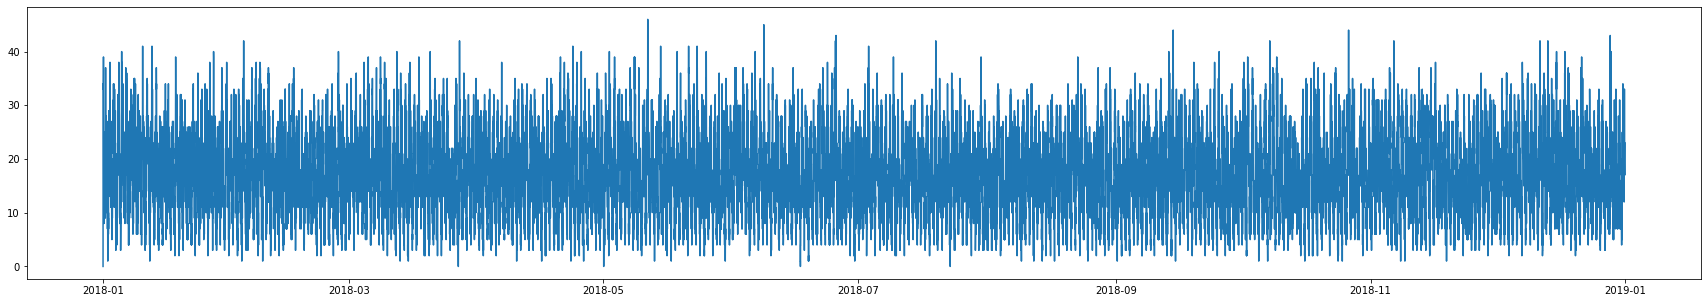

In [66]:
plt.figure(figsize=(30,5))
sns.lineplot(list(unavailable_units_15_min_int_counts.keys()),
             list(unavailable_units_15_min_int_counts.values()));

In [53]:
unavailable_units_15_min_int_counts_2018_df = pd.DataFrame(data=unavailable_units_15_min_int_counts, index=['unavail_units']).T

In [67]:
unavailable_units_15_min_int_counts_2018_df['dayofweek'] = unavailable_units_15_min_int_counts_2018_df.index.dayofweek

In [68]:
unavailable_units_15_min_int_counts_2018_df['hour'] = unavailable_units_15_min_int_counts_2018_df.index.hour

In [72]:
unavailable_units_15_min_int_counts_2018_df.head()

,unavail_units,dayofweek,hour
2018-01-01 00:00:00,0,0,0
2018-01-01 00:15:00,11,0,0
2018-01-01 00:30:00,22,0,0
2018-01-01 00:45:00,31,0,0
2018-01-01 01:00:00,31,0,1


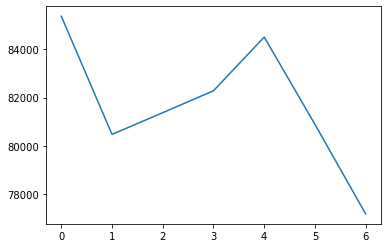

In [69]:
# Day of Week - Unavailable Units
sns.lineplot(data=unavailable_units_15_min_int_counts_2018_df.groupby('dayofweek').sum()['unavail_units'])

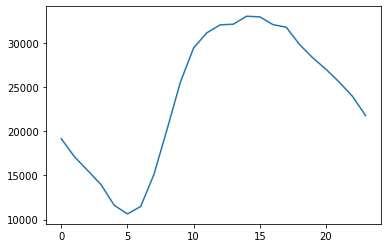

In [70]:
# Time of Day - Unavailable Units
sns.lineplot(data=unavailable_units_15_min_int_counts_2018_df.groupby('hour').sum()['unavail_units'])

In [71]:
# Largest 15 minute periods with unavailable units - 2018
unavailable_units_15_min_int_counts_2018_df['unavail_units'].nlargest(20)

2018-05-11 15:30:00    44
2018-10-26 17:45:00    44
2018-10-26 17:30:00    43
2018-12-28 11:45:00    43
2018-02-03 17:30:00    42
2018-03-27 12:00:00    42
2018-06-08 11:45:00    42
2018-06-25 15:45:00    42
2018-06-25 19:00:00    42
2018-06-25 19:15:00    42
2018-09-14 16:15:00    42
2018-11-06 14:15:00    42
2018-12-11 15:30:00    42
2018-12-13 12:45:00    42
2018-01-10 12:00:00    41
2018-04-23 16:15:00    41
2018-05-21 10:45:00    41
2018-07-19 17:30:00    41
2018-01-05 11:15:00    40
2018-05-02 10:30:00    40
Name: unavail_units, dtype: int64

In [109]:
# Pickling Unavailable Units 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','wb') as f:
        pickle.dump(unavailable_units_15_min_int_counts_2018_df,f)
        
if redo_pickle == False:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','rb') as f:
        unavailable_units_15_min_int_counts_2018_df = pickle.load(f)

In [110]:
unavailable_units_15_min_int_counts_2018_df

,unavail_units,dayofweek,hour
2018-01-01 00:00:00,0,0,0
2018-01-01 00:15:00,11,0,0
2018-01-01 00:30:00,22,0,0
2018-01-01 00:45:00,31,0,0
2018-01-01 01:00:00,31,0,1
2018-01-01 01:15:00,33,0,1
2018-01-01 01:30:00,33,0,1
2018-01-01 01:45:00,35,0,1
2018-01-01 02:00:00,34,0,2
2018-01-01 02:15:00,32,0,2


### 15 Minute Interval Ambulances Unavailable Time Series Data
- On average, who arrives first an engine or ambulance?

In [255]:
# Selecting only medics or private ambulances
Medical_2018_AMBULS = Medical_2018[(Medical_2018['Unit Type'] == 'PRIVATE') | (Medical_2018['Unit Type'] == 'MEDIC')]

In [256]:
# Finding average time(minutes) an ambulance is unavailable
((Medical_2018_AMBULS['Available DtTm'] - Medical_2018_AMBULS['Response DtTm']).dt.seconds/60).describe()

count    119462.000000
mean         61.017168
std          33.891479
min           0.000000
25%          45.066667
50%          66.925000
75%          81.350000
max        1439.850000
dtype: float64

In [284]:
Medical_2018_AMBULS

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,Supervisor Districts,Fire Prevention Districts,Current Police Districts,Neighborhoods - Analysis Boundaries,Zip Codes,Neighborhoods,Police Districts,Civic Center Harm Reduction Project Boundary,HSOC Zones,Fire_Response_Time,On_Scene_Time,Transport_Time,Hourly_DtTm
1,180010006,79,18000002,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:01:11,2018-01-01 00:01:11,2018-01-01 00:53:51,2018-01-01 00:53:55,2018-01-01 01:06:29,2018-01-01 01:11:41,2018-01-01 01:24:07,Code 2 Transport,2018-01-01 01:44:31,1900 Block of UNION ST,San Francisco,94123.0,B04,16,3443,C,2,2,True,Non Life-threatening,1,MEDIC,2.0,4,2,Marina,"(37.797609946365, -122.431831857814)",180010006-79,1.0,13.0,6.0,13.0,57.0,17.0,9.0,NaN,NaN,758.0,312.0,746.0,2018-01-01 00:00:00
2,180010015,59,18000003,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:03:58,2018-01-01 00:03:58,2018-01-01 00:03:58,2018-01-01 00:03:58,2018-01-01 00:08:05,2018-01-01 00:21:04,2018-01-01 00:21:16,Code 2 Transport,2018-01-01 00:51:13,CLAY ST/DRUMM ST,San Francisco,94111.0,B01,13,1133,3,3,3,True,Potentially Life-Threatening,1,MEDIC,2.0,1,3,Financial District/South Beach,"(37.795466113999, -122.39677157393)",180010015-59,10.0,4.0,1.0,8.0,28860.0,6.0,1.0,NaN,4.0,247.0,779.0,12.0,2018-01-01 00:00:00
4,180010023,KM07,18000005,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:04:05,2018-01-01 00:05:36,2018-01-01 00:08:00,2018-01-01 00:08:15,2018-01-01 00:12:51,2018-01-01 00:26:46,2018-01-01 00:29:12,Code 2 Transport,2018-01-01 01:01:41,0 Block of SYCAMORE ST,San Francisco,94110.0,B02,7,5423,2,2,2,False,Potentially Life-Threatening,1,PRIVATE,1.0,2,9,Mission,"(37.762744361258, -122.419834318318)",180010023-KM07,7.0,8.0,7.0,20.0,28859.0,19.0,4.0,NaN,3.0,291.0,835.0,146.0,2018-01-01 00:00:00
5,180010029,67,18000006,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:05:36,2018-01-01 00:06:36,2018-01-01 00:07:22,2018-01-01 00:08:06,2018-01-01 00:09:57,2018-01-01 00:35:14,2018-01-01 00:47:36,Code 2 Transport,2018-01-01 01:16:29,500 Block of JONES ST,San Francisco,94102.0,B01,3,1462,3,3,3,True,Potentially Life-Threatening,1,MEDIC,1.0,1,6,Tenderloin,"(37.786268441716, -122.412997235896)",180010029-67,9.0,5.0,10.0,36.0,28852.0,36.0,10.0,NaN,NaN,155.0,1517.0,742.0,2018-01-01 00:00:00
6,180010029,72,18000006,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:05:36,2018-01-01 00:06:36,2018-01-01 00:29:04,2018-01-01 00:29:07,2018-01-01 00:33:22,2018-01-01 00:41:18,2018-01-01 00:54:18,Code 2 Transport,2018-01-01 01:23:40,500 Block of JONES ST,San Francisco,94102.0,B01,3,1462,3,3,3,True,Potentially Life-Threatening,1,MEDIC,3.0,1,6,Tenderloin,"(37.786268441716, -122.412997235896)",180010029-72,9.0,5.0,10.0,36.0,28852.0,36.0,10.0,NaN,NaN,258.0,476.0,780.0,2018-01-01 00:00:00
7,180010029,KM02,18000006,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:05:36,2018-01-01 00:06:36,2018-01-01 00:28:46,NaT,NaT,NaT,NaT,Code 2 Transport,2018-01-01 00:31:22,500 Block of JONES ST,San Francisco,94102.0,B01,3,1462,3,3,3,False,Potentially Life-Threatening,1,PRIVATE,4.0,1,6,Tenderloin,"(37.786268441716, -122.412997235896)",180010029-KM02,9.0,5.0,10.0,36.0,28852.0,36.0,10.0,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00
10,180010035,KM06,18000007,Medical Incident,2018-01-01,2017-12-31,2018-01-01 00:07:36,2018-01-01 00:07:36,2018-01-01 00:30:35,2018-01-01 00:31:02,2018-01-01 00:50:01,2018-01-01 00:50:02,2018-01-01 01:01:29,Code 2 Transport,2018-01-01 01:28:27,BRYANT ST/9TH ST,San Francisco,94103.0,B03,29,2324,C,2,2,False,Non Life-threatening,1,PRIVATE,

In [297]:
Medical_2018_AMBULS[Medical_2018_AMBULS['Neighborhooods - Analysis Boundaries'] == 'Tenderloin']\
.groupby(['Neighborhooods - Analysis Boundaries','Call Date','Call Number'])\
.count()\
# .reset_index()\
# .groupby(['Neighborhooods - Analysis Boundaries','Call Date'])\
# .count()

Unit ID  \
Neighborhooods - Analysis Boundaries Call Date  Call Number            
Tenderloin                           2018-01-01 180010029          3   
                                                180010209          1   
                                                180010328          1   
                                                180010409          1   
                                                180010435          1   
                                                180010543          1   
                                                180010616          1   
                                                180010638          1   
                                                180010697          1   
                                                180010699          1   
                                                180010760          1   
                                                180010876          1   
                                                180010914          1   
                                                180011051          1   
                                                180011279          1   
                                                180011334          1   
                                                180011382          1   
                                                180011394          1   
                                                180011411          1   
                                                180011414          1   
                                                180011436          1   
                                                180011447          1   
                                                180011465          1   
                                                180011662          1   
                                                180011759          1   
                                                180011806          1   
                                                180011896          1   
                                                180011981          1   
                                                180012071          1   
                                                180012151          1   
...                                                              ...   
                                     2018-12-31 183652111          1   
                                                183652270          2   
                                                183652376          2   
                                                183652442          1   
                                                183652493          1   
                                                183652714          1   
                                                183652764          1   
                                                183652813          1   
                                                183652814          1   
                                                183652817          1   
                                                183652827          1   
                                                183652881          1   
                                                183652978          1   
                                                183652994          1   
                                                183653028          1   
                                                183653038          1   
                                                183653059          1   
                                                183653123          2   
                                                183653170          1   
                                                183653190          1   
                                                183653215          1   
                                                183653237          1   
                                                183653286          1   
                             

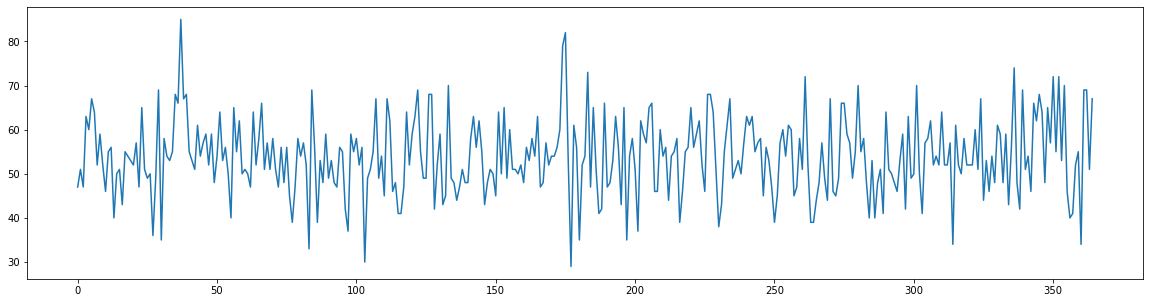

In [298]:
#  Analysis of Tenerloin Daily Call Volume
plt.figure(figsize=(20,5))
sns.lineplot(data=Medical_2018_AMBULS[Medical_2018_AMBULS['Neighborhooods - Analysis Boundaries'] == 'Tenderloin']
             .groupby(['Neighborhooods - Analysis Boundaries','Call Date'])
             .count()
             .reset_index()['Call Number'])

### 15 Minute Interval Engines Unavailable Time Series Data

In [260]:
Medical_2018_ENGS = Medical_2018[Medical_2018['Unit Type'] == 'ENGINE']

In [261]:
# Finding average time(minutes) an ambulance is unavailable
((Medical_2018_ENGS['Available DtTm'] - Medical_2018_ENGS['Response DtTm']).dt.seconds/60).describe()

count    68909.000000
mean        14.438672
std         15.018875
min          0.000000
25%          6.950000
50%         12.116667
75%         18.383333
max       1434.666667
dtype: float64

### Next Steps:
- Finish cumulative ts data - check
- Set up AWS system and get jupyter notebook running
- Begin using pyspark(converting old files into pyspark)

In [98]:
Medical_All

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,...,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,Supervisor Districts,Fire Prevention Districts,Current Police Districts,Neighborhoods - Analysis Boundaries,Zip Codes,Neighborhoods,Police Districts,Civic Center Harm Reduction Project Boundary,HSOC Zones,Fire_Response_Time,On_Scene_Time,Transport_Time,Hospital_to_Avail_Time,Unavailable_Time,Hourly_DtTm,Q_Hour_DtTm,Daily_DtTm
0,191504432,E07,19063709,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:57:59,2019-05-30 23:59:06,2019-05-30 23:59:44,2019-05-31 00:00:46,NaT,NaT,NaT,Code 2 Transport,2019-05-31 00:35:05,2300 Block of FOLSOM ST,San Francisco,94110.0,B06,7,5447,3,3,3,True,...,1,ENGINE,2.0,6,9,Mission,"(37.759693311775735, -122.41483495057777)",191504432-E07,7.0,2.0,7.0,20.0,28859.0,19.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,2121.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
1,191504432,AM116,19063709,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:57:59,2019-05-30 23:59:06,2019-05-30 23:59:44,2019-05-31 00:00:33,2019-05-31 00:02:18,2019-05-31 00:32:59,2019-05-31 00:51:14,Code 2 Transport,2019-05-31 01:04:47,2300 Block of FOLSOM ST,San Francisco,94110.0,B06,7,5447,3,3,3,False,...,1,PRIVATE,1.0,6,9,Mission,"(37.759693311775735, -122.41483495057777)",191504432-AM116,7.0,2.0,7.0,20.0,28859.0,19.0,4.0,NaN,3.0,154.0,1841.0,1095.0,813.0,3903.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
2,191504428,60,19063708,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:55:37,2019-05-30 23:57:35,2019-05-30 23:58:45,2019-05-30 23:58:59,2019-05-31 00:13:13,2019-05-31 00:45:25,2019-05-31 00:58:46,Code 2 Transport,2019-05-31 01:35:18,0 Block of RIZAL ST,San Francisco,94107.0,B03,1,2175,2,2,2,True,...,1,MEDIC,1.0,3,6,South of Market,"(37.78182211103099, -122.39929198555598)",191504428-60,9.0,6.0,2.0,34.0,28856.0,34.0,2.0,NaN,NaN,868.0,1932.0,801.0,2192.0,5793.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
6,191504421,E28,19063707,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:51:30,2019-05-30 23:53:54,2019-05-31 00:13:33,2019-05-31 00:14:49,2019-05-31 00:21:27,NaT,NaT,Code 3 Transport,2019-05-31 00:35:37,1100 Block of GREENWICH ST,San Francisco,94109.0,B01,28,1612,2,2,2,False,...,1,ENGINE,2.0,1,2,Russian Hill,"(37.80115792037051, -122.41822539893677)",191504421-E28,1.0,5.0,1.0,32.0,28858.0,32.0,1.0,NaN,NaN,474.0,NaN,NaN,NaN,1324.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
7,191504421,56,19063707,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:51:30,2019-05-30 23:53:54,2019-05-30 23:54:23,2019-05-30 23:54:28,2019-05-31 00:02:43,2019-05-31 00:36:41,2019-05-31 01:02:22,Code 3 Transport,2019-05-31 01:31:49,1100 Block of GREENWICH ST,San Francisco,94109.0,B01,28,1612,2,2,2,True,...,1,MEDIC,1.0,1,2,Russian Hill,"(37.80115792037051, -122.41822539893677)",191504421-56,1.0,5.0,1.0,32.0,28858.0,32.0,1.0,NaN,NaN,500.0,2038.0,1541.0,1767.0,5846.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
8,191504418,KM03,19063705,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:50:07,2019-05-30 23:52:39,2019-05-30 23:52:54,2019-05-30 23:53:40,2019-05-31 00:00:24,2019-05-31 00:27:13,2019-05-31 00:50:39,Code 2 Transport,2019-05-31 01:25:49,200 Block of BEACH ST,San Francisco,94133.0,B01,28,1344,2,2,2,False,...,1,PRIVATE,1.0,1,3,North Beach,"(37.80764074841426, -122.41316317597789)",191504418-KM03,10.0,3.0,1.0,23.0,308.0,23.0,1.0,NaN,NaN,450.0,1609.0,1406.0,2110.0,5575.0,2019-05-30 23:00:00,2019-05-30 23:45:00,2019-05-30
18,191504361,52,19063699,Medical Incident,2019-05-30,2019-05-30,2019-05-30 23:26:17,2019-05-30 23:28:27,2019-05-30 23:29:01,2019-05-30 23:2